#**Import**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras as keras
import pickle
import time

#visualization
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import graphviz
import seaborn as sns
from pandas.plotting import scatter_matrix

#preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MultiLabelBinarizer

# Oversampling
from imblearn.over_sampling import SMOTE

# PCA
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

# Models
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC, OneClassSVM
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import reciprocal, uniform

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_tree
from xgboost import plot_importance
from xgboost import XGBRegressor

# Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_roc_curve, roc_auc_score, roc_curve, auc
from sklearn.metrics.pairwise import rbf_kernel

# Keras
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
from keras.engine.sequential import Sequential


# **Functions**

In [ ]:
# draw histogram
def draw_hist(dataset) :
  dataset.hist(bins=50, figsize=(20,15))
  plt.show()

In [ ]:
# dataset split
def get_train_val_test(train, validation, test):           
    x_train, y_train = train.drop(['attack_cat', 'attack_type', 'difficulty_level'], axis=1), train['attack_cat']
    x_validation, y_validation = validation.drop(['attack_cat', 'attack_type', 'difficulty_level'], axis=1), validation['attack_cat']    
    x_test, y_test = test.drop(['attack_cat', 'attack_type', 'difficulty_level'], axis=1), test['attack_cat']

    x_train = pd.get_dummies(x_train) # train data set에 대한one-hot 인코딩    
    x_validation = pd.get_dummies(x_validation) # validation data set에 대한one-hot 인코딩    
    x_test = pd.get_dummies(x_test) # test data set에 대한one-hot 인코딩    

    return x_train, y_train, x_validation, y_validation, x_test, y_test

In [ ]:
# draw mulitple charts
def bake_pies(data_list,labels):
    list_length = len(data_list)
    
    # setup for mapping colors
    color_list = sns.color_palette()
    color_cycle = itertools.cycle(color_list)
    cdict = {}
    
    # build the subplots
    fig, axs = plt.subplots(1, list_length,figsize=(18,10), tight_layout=False)
    plt.subplots_adjust(wspace=1/list_length)
    
    # loop through the data sets and build the charts
    for count, data_set in enumerate(data_list): 
        
        # update our color mapt with new values
        for num, value in enumerate(np.unique(data_set.index)):
            if value not in cdict:
                cdict[value] = next(color_cycle)
       
        # build the wedges
        wedges,texts = axs[count].pie(data_set,
                           colors=[cdict[v] for v in data_set.index])

        # build the legend
        axs[count].legend(wedges, data_set.index,
                           title="Flags",
                           loc="center left",
                           bbox_to_anchor=(1, 0, 0.5, 1))
        # set the title
        axs[count].set_title(labels[count])
        
    return axs   

In [ ]:
def predict(model, x, y):
    start = time.time()

    pred = model.predict(x)
    #predictions = [round(value) for value in pred]

    print("time :", time.time() - start)    
    
    accuracy = accuracy_score(y, pred)
    print('Accuracy: %.3f%%\n\n' % accuracy )
    print(classification_report(y, pred, target_names=['Normal', 'Dos', 'Probe', 'U2R', 'R2L'])+'\n')
    print('roc auc value: %.3f%%\n\n' % roc_auc_score(y, pred, multi_class='ovr'))
    return pred


In [ ]:
def predict_nn(model, x, y):
    start=time.time()
    pred = model.predict(x)
    print("time :", time.time() - start)

    for i in pred :
      idx = np.argmax(i)
      i[idx] = 1
      j = 0
      while j < 5 :
        if i[j] != 1:
          i[j] = 0
          j=j+1
        else:
          i[j] = 1
          j=j+1  
    print(classification_report(y, pred, target_names=['Normal', 'Dos', 'Probe', 'U2R', 'R2L']))
    print('roc auc value: %.3f%%\n\n' % roc_auc_score(y, pred, multi_class='ovr'))
    return pred


In [ ]:
def sparse(pred):
  for i in pred :
    idx = np.argmax(i)
    i[idx] = 1
    j = 0
    while j < 5 :
      if i[j] != 1:
        i[j] = 0
        j=j+1
      else:
        i[j] = 1
        j=j+1  
  return pred


#**Data Import**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**KDD-NSL**

In [ ]:
NSL_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NSL_KDD-master/KDDTrain+.csv', names=['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate','attack_type','difficulty_level'])
NSL_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NSL_KDD-master/KDDTest+.csv', names=['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate','attack_type','difficulty_level'])

In [ ]:
NSL_test

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,difficulty_level
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.04,0.06,0.00,0.00,0.00,0.0,1.00,1.00,neptune,21
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.00,0.06,0.00,0.00,0.00,0.0,1.00,1.00,neptune,21
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.61,0.04,0.61,0.02,0.00,0.0,0.00,0.00,normal,21
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,1.00,0.00,1.00,0.28,0.00,0.0,0.00,0.00,saint,15
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.31,0.17,0.03,0.02,0.00,0.0,0.83,0.71,mscan,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22538,0,tcp,smtp,SF,794,333,0,0,0,0,...,0.72,0.06,0.01,0.01,0.01,0.0,0.00,0.00,normal,21
22539,0,tcp,http,SF,317,938,0,0,0,0,...,1.00,0.00,0.01,0.01,0.01,0.0,0.00,0.00,normal,21
22540,0,tcp,http,SF,54540,8314,0,0,0,2,...,1.00,0.00,0.00,0.00,0.00,0.0,0.07,0.07,back,15
22541,0,udp,domain_u,SF,42,42,0,0,0,0,...,0.99,0.01,0.00,0.00,0.00,0.0,0.00,0.00,normal,21


### Y

In [ ]:
NSL_train['attack_cat'] = NSL_train['attack_type']

#normal
NSL_train.loc[NSL_train['attack_cat'].isin(['normal']), 'attack_cat'] = 0
#dos
NSL_train.loc[NSL_train['attack_cat'].isin(['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop', 'apache2', 'processtable', 'udpstorm', 'worm', 'mailbomb']), 'attack_cat'] = 1
#probe
NSL_train.loc[NSL_train['attack_cat'].isin(['satan', 'ipsweep', 'nmap', 'portsweep','mscan', 'saint']), 'attack_cat'] = 2
#u2r
NSL_train.loc[NSL_train['attack_cat'].isin(['guess_passwd', 'ftp write', 'imap', 'phf', 'multihop', 'warezclient', 'spy', 'warezmaster', 'named', 'sendmail', 'snmpguess', 'xsnoop', 'xlock', 'snmpgetattack']), 'attack_cat'] = 3
#r2l
NSL_train.loc[NSL_train['attack_cat'].isin(['buffer_overflow', 'loadmodule', 'perl', 'rootkit', 'ftp_write', 'httptunnel', 'ps', 'sqlattack', 'xterm']), 'attack_cat'] = 4

NSL_train['attack_cat'] = pd.to_numeric(NSL_train['attack_cat'])


NSL_test['attack_cat'] = NSL_test['attack_type']

#normal
NSL_test.loc[NSL_test['attack_cat'].isin(['normal']), 'attack_cat'] = 0
#dos
NSL_test.loc[NSL_test['attack_cat'].isin(['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop', 'apache2', 'processtable', 'udpstorm', 'worm', 'mailbomb']), 'attack_cat'] = 1
#probe
NSL_test.loc[NSL_test['attack_cat'].isin(['satan', 'ipsweep', 'nmap', 'portsweep','mscan', 'saint']), 'attack_cat'] = 2
#u2r
NSL_test.loc[NSL_test['attack_cat'].isin(['guess_passwd', 'ftp write', 'imap', 'phf', 'multihop', 'warezclient', 'spy', 'warezmaster', 'named', 'sendmail', 'snmpguess', 'xsnoop', 'xlock', 'snmpgetattack']), 'attack_cat'] = 3
#r2l
NSL_test.loc[NSL_test['attack_cat'].isin(['buffer_overflow', 'loadmodule', 'perl', 'rootkit', 'ftp_write', 'httptunnel', 'ps', 'sqlattack', 'xterm']), 'attack_cat'] = 4

NSL_test['attack_cat'] = pd.to_numeric(NSL_test['attack_cat'])


In [ ]:
NSL_train['attack_cat'].unique()

array([0, 1, 3, 2, 4])

Text(0, 0.5, 'Number of Records')

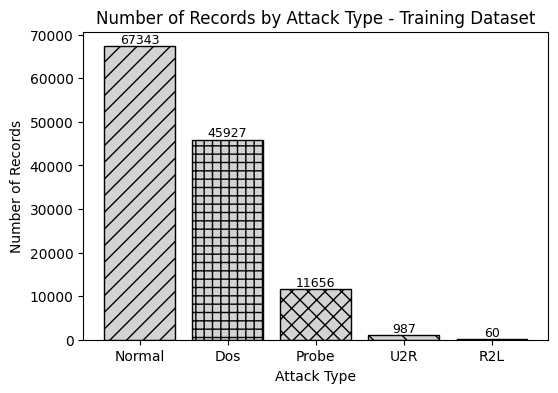

In [ ]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 10

x = ["Normal", "Dos", "Probe", "U2R", "R2L"]
y = NSL_train.attack_cat.value_counts()

plt.bar(x, y)

bars = plt.bar(x, y, color='lightgray', edgecolor='black')
bars[0].set_hatch('//')
bars[1].set_hatch('++')
bars[2].set_hatch('XX')
bars[3].set_hatch('\\')
bars[4].set_hatch('*')

for i, v in enumerate(x):
    plt.text(v, y[i], y[i],
             fontsize=9,
             color='black',
             horizontalalignment='center',
             verticalalignment='bottom')

plt.title("Number of Records by Attack Type - Training Dataset")
plt.xlabel("Attack Type")
plt.ylabel("Number of Records")

Text(0, 0.5, 'Number of Records')

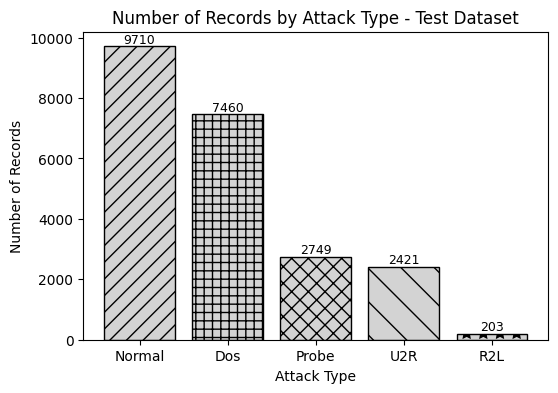

In [ ]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 10

x = ["Normal", "Dos", "Probe", "U2R", "R2L"]
y = NSL_test.attack_cat.value_counts()

plt.bar(x, y)

bars = plt.bar(x, y, color='lightgray', edgecolor='black')
bars[0].set_hatch('//')
bars[1].set_hatch('++')
bars[2].set_hatch('XX')
bars[3].set_hatch('\\')
bars[4].set_hatch('*')

plt.text("Normal", y[0], y[0],
        fontsize=9,
        color='black',
        horizontalalignment='center',
        verticalalignment='bottom')
plt.text("Dos", y[1], y[1],
        fontsize=9,
        color='black',
        horizontalalignment='center',
        verticalalignment='bottom')
plt.text("Probe", y[3], y[3],
        fontsize=9,
        color='black',
        horizontalalignment='center',
        verticalalignment='bottom')
plt.text("U2R", y[2], y[2],
        fontsize=9,
        color='black',
        horizontalalignment='center',
        verticalalignment='bottom')
plt.text("R2L", y[4], y[4],
        fontsize=9,
        color='black',
        horizontalalignment='center',
        verticalalignment='bottom')

plt.title("Number of Records by Attack Type - Test Dataset")
plt.xlabel("Attack Type")
plt.ylabel("Number of Records")


### Scaling

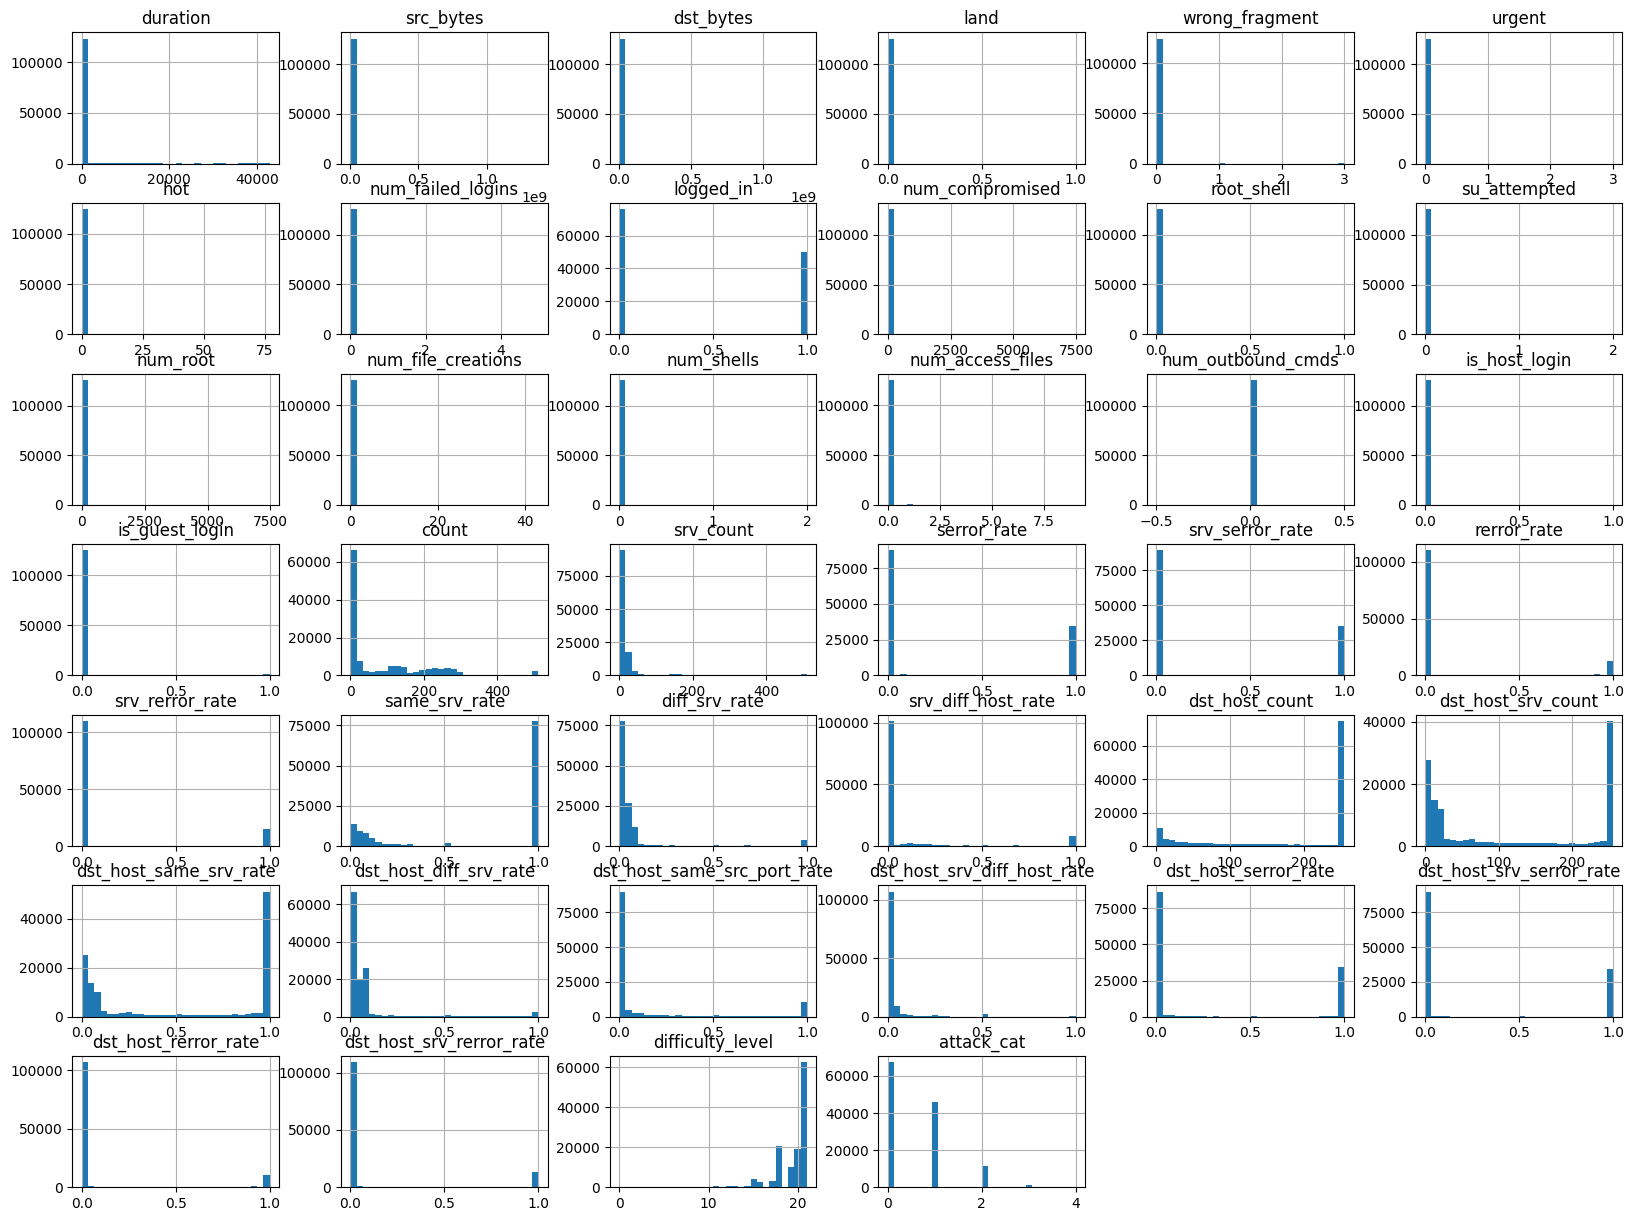

In [ ]:
NSL_train.hist(bins=30, figsize=(20,15))
plt.show()

In [ ]:
# 스케일링을 위한 Flags 종류 단순화
NSL_train.loc[NSL_train['flag'].isin(['SH', 'S3', 'S1', 'S2']), 'flag'] = 'OTH' # flag_OTH로 묶기
NSL_test.loc[NSL_test['flag'].isin(['SH', 'S3', 'S1', 'S2']), 'flag'] = 'OTH' # flag_OTH로 묶기

# 스케일링을 위한 service 종류 단순화
NSL_train.loc[~NSL_train['service'].isin(['http', 'domain_u', 'smtp', 'ftp_data', 'private', 'ftp', 'telnet', 'ecr_i', 'finger', 'z39_50', 'eco_i']), 'service'] = 'other' # 빼고는 state_othres로 묶기
NSL_test.loc[~NSL_test['service'].isin(['http', 'domain_u', 'smtp', 'ftp_data', 'private', 'ftp', 'telnet', 'ecr_i', 'finger', 'z39_50', 'eco_i']), 'service'] = 'other' # 빼고는 state_othres로 묶기

In [ ]:
NSL_train.flag.value_counts()

SF        74945
S0        34851
REJ       11233
RSTR       2421
RSTO       1562
OTH         858
RSTOS0      103
Name: flag, dtype: int64

In [ ]:
NSL_test.flag.value_counts()

SF        14874
REJ        3850
S0         2013
RSTO        773
RSTR        669
OTH         362
RSTOS0        2
Name: flag, dtype: int64

In [ ]:
NSL_train.service.value_counts()

http        40338
other       27029
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
eco_i        4586
ecr_i        3077
telnet       2353
finger       1767
ftp          1754
Name: service, dtype: int64

In [ ]:
NSL_test.service.value_counts()

http        7853
private     4774
other       3769
telnet      1626
smtp         934
domain_u     894
ftp_data     851
ecr_i        752
ftp          692
eco_i        262
finger       136
Name: service, dtype: int64

In [ ]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, val_index in split.split(NSL_train, NSL_train['attack_cat']):
  train = NSL_train.loc[train_index]
  val = NSL_train.loc[val_index]

In [ ]:
nsl_train_x, nsl_train_y, nsl_val_x, nsl_val_y, nsl_test_x, nsl_test_y = get_train_val_test(train, val, NSL_test)


In [ ]:
# feature Scaling
scaler=StandardScaler()
scaler.fit(nsl_train_x)
nsl_train_x_scaled=scaler.transform(nsl_train_x)
nsl_val_x_scaled=scaler.transform(nsl_val_x)
nsl_test_x_scaled=scaler.transform(nsl_test_x)

In [ ]:
nsl_train_y_one = tf.keras.utils.to_categorical(nsl_train_y)
nsl_val_y_one = tf.keras.utils.to_categorical(nsl_val_y)
nsl_test_y_one = tf.keras.utils.to_categorical(nsl_test_y)

In [ ]:
nsl_train_y_one

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
NSL_train.loc[NSL_train['attack_cat'].isin(['normal']), 'attack_cat'] = 0
#dos
NSL_train.loc[NSL_train['attack_cat'].isin(['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop', 'apache2', 'processtable', 'udpstorm', 'worm', 'mailbomb']), 'attack_cat'] = 1
#probe
NSL_train.loc[NSL_train['attack_cat'].isin(['satan', 'ipsweep', 'nmap', 'portsweep','mscan', 'saint']), 'attack_cat'] = 2
#u2r
NSL_train.loc[NSL_train['attack_cat'].isin(['guess_passwd', 'ftp write', 'imap', 'phf', 'multihop', 'warezclient', 'spy', 'warezmaster', 'named', 'sendmail', 'snmpguess', 'xsnoop', 'xlock', 'snmpgetattack']), 'attack_cat'] = 3
#r2l
NSL_train.loc[NSL_train['attack_cat'].isin(['buffer_overflow', 'loadmodule', 'perl', 'rootkit', 'ftp_write', 'httptunnel', 'ps', 'sqlattack', 'xterm']), 'attack_cat'] = 4



#**Models**

## **Baseline(None)**

### **SVM**

In [ ]:
start = time.time()

svm = OneVsRestClassifier(SVC(kernel="rbf", gamma=1, C=10))
svm.fit(nsl_train_x_scaled, nsl_train_y_one)

print("time :", time.time() - start)

time : 2504.8109447956085


In [ ]:
predict(svm, nsl_val_x_scaled, nsl_val_y_one)

time : 86.85033917427063
Accuracy: 0.995%


              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00     13469
         Dos       1.00      1.00      1.00      9186
       Probe       1.00      0.97      0.98      2331
         U2R       0.96      0.88      0.92       197
         R2L       0.75      0.25      0.38        12

   micro avg       1.00      0.99      1.00     25195
   macro avg       0.94      0.82      0.85     25195
weighted avg       1.00      0.99      0.99     25195
 samples avg       0.99      0.99      0.99     25195


roc auc value: 0.909%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [ ]:
predict(svm, nsl_test_x_scaled, nsl_test_y_one)

time : 79.3085298538208
Accuracy: 0.706%


              precision    recall  f1-score   support

      Normal       0.60      0.99      0.75      9710
         Dos       0.99      0.71      0.83      7460
       Probe       0.92      0.42      0.58      2421
         U2R       0.90      0.01      0.03      2749
         R2L       0.00      0.00      0.00       203

   micro avg       0.71      0.71      0.71     22543
   macro avg       0.68      0.43      0.44     22543
weighted avg       0.80      0.71      0.66     22543
 samples avg       0.71      0.71      0.71     22543


roc auc value: 0.664%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

### RF

In [ ]:
params = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }

rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 3, n_jobs = -1)
grid_cv.fit(nsl_train_x_scaled, nsl_train_y_one)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:  {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 100}
최고 예측 정확도: 0.9963


In [ ]:
start = time.time()

rf = RandomForestClassifier(n_estimators=100, min_samples_split=20, min_samples_leaf=8, max_depth=12, n_jobs=-1)
rf.fit(nsl_train_x_scaled, nsl_train_y_one)

print("time :", time.time() - start)

time : 8.08535099029541


In [ ]:
predict(rf, nsl_val_x_scaled, nsl_val_y_one)

time : 0.5877799987792969
Accuracy: 0.996%


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     13469
         Dos       1.00      1.00      1.00      9186
       Probe       1.00      0.98      0.99      2331
         U2R       0.99      0.80      0.89       197
         R2L       0.00      0.00      0.00        12

   micro avg       1.00      1.00      1.00     25195
   macro avg       0.80      0.76      0.78     25195
weighted avg       1.00      1.00      1.00     25195
 samples avg       1.00      1.00      1.00     25195


roc auc value: 0.878%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
predict(rf, nsl_test_x_scaled, nsl_test_y_one)

time : 0.9288337230682373
Accuracy: 0.741%


              precision    recall  f1-score   support

      Normal       0.66      0.97      0.79      9710
         Dos       0.96      0.77      0.85      7460
       Probe       0.88      0.59      0.70      2421
         U2R       1.00      0.04      0.08      2749
         R2L       0.00      0.00      0.00       203

   micro avg       0.76      0.74      0.75     22543
   macro avg       0.70      0.47      0.48     22543
weighted avg       0.82      0.74      0.71     22543
 samples avg       0.74      0.74      0.74     22543


roc auc value: 0.697%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

###KNN


In [ ]:
start = time.time()

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(nsl_train_x_scaled, nsl_train_y_one)

print("time :", time.time() - start)

time : 0.028630971908569336


In [ ]:
predict(knn, nsl_val_x_scaled, nsl_val_y_one)

time : 29.28916597366333
Accuracy: 0.997%


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     13469
         Dos       1.00      1.00      1.00      9186
       Probe       0.99      0.99      0.99      2331
         U2R       0.95      0.93      0.94       197
         R2L       0.50      0.50      0.50        12

   micro avg       1.00      1.00      1.00     25195
   macro avg       0.89      0.88      0.89     25195
weighted avg       1.00      1.00      1.00     25195
 samples avg       1.00      1.00      1.00     25195


roc auc value: 0.941%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
predict(knn, nsl_test_x_scaled, nsl_test_y_one)

time : 26.209755420684814
Accuracy: 0.770%


              precision    recall  f1-score   support

      Normal       0.67      0.97      0.79      9710
         Dos       0.96      0.81      0.88      7460
       Probe       0.85      0.75      0.80      2421
         U2R       0.95      0.03      0.06      2749
         R2L       0.36      0.11      0.17       203

   micro avg       0.77      0.77      0.77     22543
   macro avg       0.76      0.53      0.54     22543
weighted avg       0.82      0.77      0.73     22543
 samples avg       0.77      0.77      0.77     22543


roc auc value: 0.728%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

###XGBoost

In [ ]:
xgb = XGBClassifier()
xg_parameters ={'max_depth' : [3,4,5,6] , 'n_estimators': [12,24,32], 'learning_rate':[0.01, 0.1], 'gamma': [0.5, 1, 2], 'random_state':42}
grid_search_xg = GridSearchCV(xgb, param_grid = xg_parameters, scoring = 'accuracy', cv = 10)
grid_search_xg.fit(nsl_train_x_scaled, nsl_train_y)
best_xgb = grid_search_xg.best_estimator_
best_xgb 

ValueError: ignored

In [ ]:
start=time.time()
xgb = OneVsRestClassifier(XGBClassifier(gamma=2, max_depth=6, n_estimators=32, random_state=42))
xgb.fit(nsl_train_x_scaled, nsl_train_y_one)
print("time :", time.time() - start)

#objective='multi:softprob',

time : 31.323578596115112


In [ ]:
predict(xgb, nsl_val_x_scaled, nsl_val_y_one)

time : 0.13462543487548828
Accuracy: 0.996%


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     13469
         Dos       1.00      1.00      1.00      9186
       Probe       1.00      0.99      0.99      2331
         U2R       0.99      0.95      0.97       197
         R2L       1.00      0.42      0.59        12

   micro avg       1.00      1.00      1.00     25195
   macro avg       1.00      0.87      0.91     25195
weighted avg       1.00      1.00      1.00     25195
 samples avg       1.00      1.00      1.00     25195


roc auc value: 0.935%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [ ]:
pred = predict(xgb, nsl_test_x_scaled, nsl_test_y_one)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


time : 0.12524962425231934
Accuracy: 0.753%


              precision    recall  f1-score   support

      Normal       0.67      0.97      0.80      9710
         Dos       0.96      0.83      0.89      7460
       Probe       0.79      0.70      0.75      2421
         U2R       0.99      0.16      0.28      2749
         R2L       0.67      0.03      0.06       203

   micro avg       0.77      0.79      0.78     22543
   macro avg       0.82      0.54      0.55     22543
weighted avg       0.82      0.79      0.75     22543
 samples avg       0.77      0.79      0.78     22543


roc auc value: 0.731%




###DNN

In [ ]:
from keras.backend import dropout
model_dnn = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(59,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),  
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(5, activation="softmax")
])
model_dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 59)                0         
                                                                 
 batch_normalization (BatchN  (None, 59)               236       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 300)               18000     
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               3

In [ ]:
model_dnn.compile(loss = "categorical_crossentropy",
                  optimizer = "nadam",                  
                  metrics=["Accuracy"]
                  )

In [ ]:
history_dnn = model_dnn.fit(nsl_train_x_scaled, nsl_train_y_one, epochs=30,
                        validation_data=(nsl_val_x_scaled, nsl_val_y_one))

Epoch 1/30
3150/3150 [==============================] - 14s 4ms/step - loss: 0.0635 - Accuracy: 0.9806 - val_loss: 0.1731 - val_Accuracy: 0.9799
Epoch 2/30
3150/3150 [==============================] - 12s 4ms/step - loss: 0.0352 - Accuracy: 0.9884 - val_loss: 0.1980 - val_Accuracy: 0.9773
Epoch 3/30
3150/3150 [==============================] - 11s 4ms/step - loss: 0.0321 - Accuracy: 0.9891 - val_loss: 0.2074 - val_Accuracy: 0.9812
Epoch 4/30
3150/3150 [==============================] - 12s 4ms/step - loss: 0.0287 - Accuracy: 0.9903 - val_loss: 0.3804 - val_Accuracy: 0.9809
Epoch 5/30
3150/3150 [==============================] - 12s 4ms/step - loss: 0.0270 - Accuracy: 0.9911 - val_loss: 0.1477 - val_Accuracy: 0.9846
Epoch 6/30
3150/3150 [==============================] - 12s 4ms/step - loss: 0.0247 - Accuracy: 0.9912 - val_loss: 0.1684 - val_Accuracy: 0.9833
Epoch 7/30
3150/3150 [==============================] - 12s 4ms/step - loss: 0.0237 - Accuracy: 0.9917 - val_loss: 0.3246 - val_Ac

In [ ]:
model_dnn.evaluate(nsl_test_x_scaled, nsl_test_y_one)

705/705 [==============================] - 1s 2ms/step - loss: 5.0465 - Accuracy: 0.7604


[5.046527862548828, 0.760369062423706]

In [ ]:
predict_nn(model_dnn, nsl_val_x_scaled, nsl_val_y_one)

788/788 [==============================] - 1s 2ms/step
time : 1.636829137802124
              precision    recall  f1-score   support

      Normal       0.98      0.99      0.99     13469
         Dos       1.00      0.98      0.99      9186
       Probe       0.99      0.98      0.98      2331
         U2R       0.86      0.64      0.73       197
         R2L       0.11      0.50      0.17        12

   micro avg       0.98      0.98      0.98     25195
   macro avg       0.79      0.82      0.77     25195
weighted avg       0.99      0.98      0.98     25195
 samples avg       0.98      0.98      0.98     25195

roc auc value: 0.906%




array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
predict_nn(model_dnn, nsl_test_x_scaled, nsl_test_y_one)

705/705 [==============================] - 1s 2ms/step
time : 1.7229461669921875
              precision    recall  f1-score   support

      Normal       0.67      0.92      0.78      9710
         Dos       0.96      0.80      0.87      7460
       Probe       0.70      0.70      0.70      2421
         U2R       0.98      0.18      0.31      2749
         R2L       0.51      0.19      0.28       203

   micro avg       0.76      0.76      0.76     22543
   macro avg       0.76      0.56      0.59     22543
weighted avg       0.81      0.76      0.74     22543
 samples avg       0.76      0.76      0.76     22543

roc auc value: 0.740%




array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

### **CNN**

In [ ]:
cnn = keras.models.Sequential([
    keras.layers.Conv1D(64, 7, activation='relu', padding='same', input_shape=[59, 1]),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation='softmax'),
])

In [ ]:
cnn.compile(loss = "categorical_crossentropy",
            optimizer = "nadam",
            metrics=["Accuracy"]
            )

In [ ]:
start=time.time()
history_cnn = cnn.fit(nsl_train_x_scaled, nsl_train_y_one, epochs=30,
                      validation_data=(nsl_val_x_scaled, nsl_val_y_one))
print("time :", time.time() - start)

Epoch 1/30
3150/3150 [==============================] - 207s 65ms/step - loss: 0.0794 - Accuracy: 0.9770 - val_loss: 0.0383 - val_Accuracy: 0.9890
Epoch 2/30
3150/3150 [==============================] - 193s 61ms/step - loss: 0.0408 - Accuracy: 0.9887 - val_loss: 0.0277 - val_Accuracy: 0.9911
Epoch 3/30
3150/3150 [==============================] - 190s 60ms/step - loss: 0.0335 - Accuracy: 0.9902 - val_loss: 0.0261 - val_Accuracy: 0.9910
Epoch 4/30
3150/3150 [==============================] - 191s 61ms/step - loss: 0.0294 - Accuracy: 0.9917 - val_loss: 0.0244 - val_Accuracy: 0.9917
Epoch 5/30
3150/3150 [==============================] - 190s 60ms/step - loss: 0.0278 - Accuracy: 0.9921 - val_loss: 0.0235 - val_Accuracy: 0.9929
Epoch 6/30
3150/3150 [==============================] - 192s 61ms/step - loss: 0.0290 - Accuracy: 0.9927 - val_loss: 0.0234 - val_Accuracy: 0.9926
Epoch 7/30
3150/3150 [==============================] - 189s 60ms/step - loss: 0.0247 - Accuracy: 0.9933 - val_loss: 0

In [ ]:
cnn.evaluate(nsl_test_x_scaled, nsl_test_y_one)

705/705 [==============================] - 9s 13ms/step - loss: 10.5138 - Accuracy: 0.7510


[10.513846397399902, 0.7510091662406921]

In [ ]:
predict_nn(cnn, nsl_val_x_scaled, nsl_val_y_one)

788/788 [==============================] - 10s 13ms/step
time : 20.525670289993286
              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99     13469
         Dos       1.00      1.00      1.00      9186
       Probe       1.00      0.96      0.98      2331
         U2R       0.99      0.75      0.85       197
         R2L       0.00      0.00      0.00        12

   micro avg       0.99      0.99      0.99     25195
   macro avg       0.79      0.74      0.76     25195
weighted avg       0.99      0.99      0.99     25195
 samples avg       0.99      0.99      0.99     25195

roc auc value: 0.869%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
predict_nn(cnn, nsl_test_x_scaled, nsl_test_y_one)

705/705 [==============================] - 11s 16ms/step
time : 11.594406604766846
              precision    recall  f1-score   support

      Normal       0.65      0.97      0.78      9710
         Dos       0.97      0.77      0.86      7460
       Probe       0.82      0.62      0.70      2421
         U2R       0.83      0.12      0.21      2749
         R2L       0.00      0.00      0.00       203

   micro avg       0.75      0.75      0.75     22543
   macro avg       0.65      0.49      0.51     22543
weighted avg       0.79      0.75      0.72     22543
 samples avg       0.75      0.75      0.75     22543

roc auc value: 0.705%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

## **PCA30**

In [ ]:
pca30 = PCA(n_components=30)
pca30.fit(nsl_train_x_scaled)
nsl_pca30_train = pca30.transform(nsl_train_x_scaled)
nsl_pca30_val = pca30.transform(nsl_val_x_scaled)
nsl_pca30_test = pca30.transform(nsl_test_x_scaled)

scaler.fit(nsl_pca30_train)
nsl_pca30_train_scaled=scaler.transform(nsl_pca30_train)
nsl_pca30_val_scaled=scaler.transform(nsl_pca30_val)
nsl_pca30_test_scaled=scaler.transform(nsl_pca30_test)


###**SVM**

In [ ]:
start = time.time()
rbf30_kernel_svm_clf = OneVsRestClassifier(SVC(kernel="rbf", gamma=1, C=10))
rbf30_kernel_svm_clf.fit(nsl_pca30_train_scaled, nsl_train_y_one)

print("time :", time.time() - start)

time : 837.0143296718597


In [ ]:
predict(rbf30_kernel_svm_clf, nsl_pca30_val_scaled, nsl_val_y_one)

time : 34.82710933685303
Accuracy: 0.995%


              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00     13469
         Dos       1.00      1.00      1.00      9186
       Probe       0.99      0.98      0.99      2331
         U2R       0.98      0.89      0.93       197
         R2L       0.43      0.25      0.32        12

   micro avg       1.00      1.00      1.00     25195
   macro avg       0.88      0.82      0.85     25195
weighted avg       1.00      1.00      1.00     25195
 samples avg       1.00      1.00      1.00     25195


roc auc value: 0.911%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [ ]:
predict(rbf30_kernel_svm_clf, nsl_pca30_test_scaled, nsl_test_y_one)

time : 31.2977933883667
Accuracy: 0.728%


              precision    recall  f1-score   support

      Normal       0.63      0.97      0.77      9710
         Dos       0.98      0.78      0.87      7460
       Probe       0.86      0.48      0.61      2421
         U2R       0.91      0.00      0.01      2749
         R2L       0.14      0.03      0.05       203

   micro avg       0.74      0.73      0.73     22543
   macro avg       0.71      0.45      0.46     22543
weighted avg       0.80      0.73      0.69     22543
 samples avg       0.73      0.73      0.73     22543


roc auc value: 0.682%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

###**RF**

In [ ]:
start=time.time()

rf30 = RandomForestClassifier(n_estimators=100, min_samples_split=20, min_samples_leaf=8, max_depth=12, n_jobs=-1)
rf30.fit(nsl_pca30_train_scaled, nsl_train_y_one)

print("time :", time.time() - start)

time : 101.0095157623291


In [ ]:
predict(rf30, nsl_pca30_val_scaled, nsl_val_y_one)

time : 0.7590372562408447
Accuracy: 0.994%


              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00     13469
         Dos       1.00      1.00      1.00      9186
       Probe       1.00      0.97      0.98      2331
         U2R       0.98      0.83      0.90       197
         R2L       0.67      0.17      0.27        12

   micro avg       0.99      0.99      0.99     25195
   macro avg       0.93      0.79      0.83     25195
weighted avg       0.99      0.99      0.99     25195
 samples avg       0.99      0.99      0.99     25195


roc auc value: 0.895%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
predict(rf30, nsl_pca30_test_scaled, nsl_test_y_one)

time : 0.6958529949188232
Accuracy: 0.739%


              precision    recall  f1-score   support

      Normal       0.66      0.93      0.77      9710
         Dos       0.97      0.82      0.89      7460
       Probe       0.88      0.61      0.72      2421
         U2R       0.95      0.01      0.01      2749
         R2L       0.33      0.02      0.04       203

   micro avg       0.77      0.74      0.75     22543
   macro avg       0.76      0.48      0.49     22543
weighted avg       0.82      0.74      0.71     22543
 samples avg       0.74      0.74      0.74     22543


roc auc value: 0.700%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

###KNN

In [ ]:
start = time.time()

knn30 = KNeighborsClassifier(n_neighbors=3)
knn30.fit(nsl_pca30_train_scaled, nsl_train_y_one)

print("time :", time.time() - start)

time : 0.05162787437438965


In [ ]:
predict(knn30,nsl_pca30_val_scaled, nsl_val_y_one)

time : 42.812260150909424
Accuracy: 0.996%


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     13469
         Dos       1.00      1.00      1.00      9186
       Probe       0.99      0.98      0.99      2331
         U2R       0.95      0.93      0.94       197
         R2L       0.56      0.42      0.48        12

   micro avg       1.00      1.00      1.00     25195
   macro avg       0.90      0.86      0.88     25195
weighted avg       1.00      1.00      1.00     25195
 samples avg       1.00      1.00      1.00     25195


roc auc value: 0.932%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
predict(knn30,nsl_pca30_test_scaled, nsl_test_y_one)

time : 37.95328903198242
Accuracy: 0.771%


              precision    recall  f1-score   support

      Normal       0.68      0.97      0.80      9710
         Dos       0.95      0.82      0.88      7460
       Probe       0.84      0.69      0.76      2421
         U2R       0.95      0.07      0.13      2749
         R2L       0.56      0.11      0.18       203

   micro avg       0.77      0.77      0.77     22543
   macro avg       0.80      0.53      0.55     22543
weighted avg       0.82      0.77      0.73     22543
 samples avg       0.77      0.77      0.77     22543


roc auc value: 0.727%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

###XGBoost

In [ ]:
start=time.time()

xgb30 =  OneVsRestClassifier(XGBClassifier(gamma=2, max_depth=6, n_estimators=32, random_state=42))
xgb30.fit(nsl_pca30_train_scaled, nsl_train_y_one)

print("time :", time.time() - start)

time : 75.7438223361969


In [ ]:
predict(xgb30,nsl_pca30_val_scaled, nsl_val_y_one)

time : 0.16507625579833984
Accuracy: 0.991%


              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99     13469
         Dos       1.00      1.00      1.00      9186
       Probe       0.99      0.97      0.98      2331
         U2R       0.98      0.85      0.91       197
         R2L       0.75      0.25      0.38        12

   micro avg       0.99      0.99      0.99     25195
   macro avg       0.94      0.81      0.85     25195
weighted avg       0.99      0.99      0.99     25195
 samples avg       0.99      0.99      0.99     25195


roc auc value: 0.906%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [ ]:
predict(xgb30,nsl_pca30_test_scaled, nsl_test_y_one)

time : 0.15664076805114746
Accuracy: 0.753%


              precision    recall  f1-score   support

      Normal       0.68      0.97      0.80      9710
         Dos       0.96      0.81      0.88      7460
       Probe       0.88      0.68      0.77      2421
         U2R       0.87      0.01      0.02      2749
         R2L       0.38      0.04      0.08       203

   micro avg       0.78      0.76      0.77     22543
   macro avg       0.76      0.50      0.51     22543
weighted avg       0.82      0.76      0.72     22543
 samples avg       0.76      0.76      0.76     22543


roc auc value: 0.715%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]])

###DNN

In [ ]:
from keras.backend import dropout
dnn30 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(30,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),  
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(5, activation="softmax")
])
dnn30.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 30)                0         
                                                                 
 batch_normalization_3 (Batc  (None, 30)               120       
 hNormalization)                                                 
                                                                 
 dense_12 (Dense)            (None, 300)               9300      
                                                                 
 dropout_8 (Dropout)         (None, 300)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_13 (Dense)            (None, 100)              

In [ ]:
dnn30.compile(loss="categorical_crossentropy",
              optimizer="nadam",
              metrics=["accuracy"])

In [ ]:
history_dnn30 = dnn30.fit(nsl_pca30_train_scaled, nsl_train_y_one, epochs=30,
                          validation_data=(nsl_pca30_val_scaled, nsl_val_y_one))

Epoch 1/30
3150/3150 [==============================] - 13s 4ms/step - loss: 0.1029 - accuracy: 0.9677 - val_loss: 0.0926 - val_accuracy: 0.9803
Epoch 2/30
3150/3150 [==============================] - 11s 4ms/step - loss: 0.0582 - accuracy: 0.9803 - val_loss: 0.1137 - val_accuracy: 0.9823
Epoch 3/30
3150/3150 [==============================] - 13s 4ms/step - loss: 0.0496 - accuracy: 0.9826 - val_loss: 0.0717 - val_accuracy: 0.9815
Epoch 4/30
3150/3150 [==============================] - 11s 3ms/step - loss: 0.0472 - accuracy: 0.9840 - val_loss: 0.1189 - val_accuracy: 0.9791
Epoch 5/30
3150/3150 [==============================] - 13s 4ms/step - loss: 0.0441 - accuracy: 0.9847 - val_loss: 0.0794 - val_accuracy: 0.9846
Epoch 6/30
3150/3150 [==============================] - 13s 4ms/step - loss: 0.0420 - accuracy: 0.9855 - val_loss: 0.0793 - val_accuracy: 0.9831
Epoch 7/30
3150/3150 [==============================] - 13s 4ms/step - loss: 0.0398 - accuracy: 0.9861 - val_loss: 0.0882 - val_ac

In [ ]:
dnn30.evaluate(nsl_pca30_test_scaled, nsl_test_y_one)

705/705 [==============================] - 1s 2ms/step - loss: 8.8786 - accuracy: 0.7559


[8.878591537475586, 0.7558887600898743]

In [ ]:
predict_nn(dnn30, nsl_pca30_val_scaled, nsl_val_y_one)

788/788 [==============================] - 2s 3ms/step
time : 2.7599496841430664
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99     13469
         Dos       0.99      1.00      1.00      9186
       Probe       0.99      0.97      0.98      2331
         U2R       0.75      0.43      0.54       197
         R2L       0.26      0.58      0.36        12

   micro avg       0.99      0.99      0.99     25195
   macro avg       0.80      0.79      0.77     25195
weighted avg       0.99      0.99      0.99     25195
 samples avg       0.99      0.99      0.99     25195

roc auc value: 0.894%




array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
predict_nn(dnn30, nsl_pca30_test_scaled, nsl_test_y_one)

705/705 [==============================] - 2s 3ms/step
time : 2.6694483757019043
              precision    recall  f1-score   support

      Normal       0.66      0.93      0.77      9710
         Dos       0.91      0.83      0.87      7460
       Probe       0.85      0.71      0.78      2421
         U2R       0.96      0.02      0.05      2749
         R2L       0.63      0.16      0.25       203

   micro avg       0.76      0.76      0.76     22543
   macro avg       0.80      0.53      0.54     22543
weighted avg       0.80      0.76      0.71     22543
 samples avg       0.76      0.76      0.76     22543

roc auc value: 0.724%




array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

###**CNN**

In [ ]:
cnn30 = keras.models.Sequential([
    keras.layers.Conv1D(64, 7, activation='relu', padding='same', input_shape=[30, 1]),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation='softmax'),
])

In [ ]:
cnn30.compile(loss = "categorical_crossentropy",
              optimizer = "nadam",
              metrics=["Accuracy"]
              )

In [ ]:
start=time.time()
history_cnn = cnn30.fit(nsl_pca30_train_scaled, nsl_train_y_one, epochs=30,
                        validation_data=(nsl_pca30_val_scaled, nsl_val_y_one))
print("time :", time.time() - start)


Epoch 1/30
3150/3150 [==============================] - 190s 60ms/step - loss: 0.0926 - Accuracy: 0.9735 - val_loss: 0.0358 - val_Accuracy: 0.9883
Epoch 2/30
3150/3150 [==============================] - 165s 52ms/step - loss: 0.0486 - Accuracy: 0.9863 - val_loss: 0.0366 - val_Accuracy: 0.9889
Epoch 3/30
3150/3150 [==============================] - 150s 48ms/step - loss: 0.0406 - Accuracy: 0.9885 - val_loss: 0.0411 - val_Accuracy: 0.9871
Epoch 4/30
3150/3150 [==============================] - 157s 50ms/step - loss: 0.0371 - Accuracy: 0.9903 - val_loss: 0.0375 - val_Accuracy: 0.9897
Epoch 5/30
3150/3150 [==============================] - 152s 48ms/step - loss: 0.0360 - Accuracy: 0.9904 - val_loss: 0.0311 - val_Accuracy: 0.9896
Epoch 6/30
3150/3150 [==============================] - 152s 48ms/step - loss: 0.0312 - Accuracy: 0.9915 - val_loss: 0.0372 - val_Accuracy: 0.9904
Epoch 7/30
3150/3150 [==============================] - 150s 48ms/step - loss: 0.0342 - Accuracy: 0.9912 - val_loss: 0

In [ ]:
cnn30.evaluate(nsl_pca30_test_scaled, nsl_test_y_one)

705/705 [==============================] - 7s 10ms/step - loss: 3.6132 - Accuracy: 0.7508


[3.613234043121338, 0.7508317232131958]

In [ ]:
predict_nn(cnn30, nsl_pca30_val_scaled, nsl_val_y_one)

788/788 [==============================] - 8s 10ms/step
time : 7.883238315582275
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99     13469
         Dos       1.00      1.00      1.00      9186
       Probe       0.98      0.98      0.98      2331
         U2R       0.87      0.79      0.83       197
         R2L       0.00      0.00      0.00        12

   micro avg       0.99      0.99      0.99     25195
   macro avg       0.77      0.75      0.76     25195
weighted avg       0.99      0.99      0.99     25195
 samples avg       0.99      0.99      0.99     25195

roc auc value: 0.875%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
predict_nn(cnn30, nsl_pca30_test_scaled, nsl_test_y_one)

705/705 [==============================] - 7s 10ms/step
time : 7.176801919937134
              precision    recall  f1-score   support

      Normal       0.66      0.94      0.78      9710
         Dos       0.90      0.76      0.83      7460
       Probe       0.85      0.78      0.81      2421
         U2R       0.99      0.08      0.15      2749
         R2L       0.00      0.00      0.00       203

   micro avg       0.75      0.75      0.75     22543
   macro avg       0.68      0.51      0.51     22543
weighted avg       0.80      0.75      0.71     22543
 samples avg       0.75      0.75      0.75     22543

roc auc value: 0.714%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

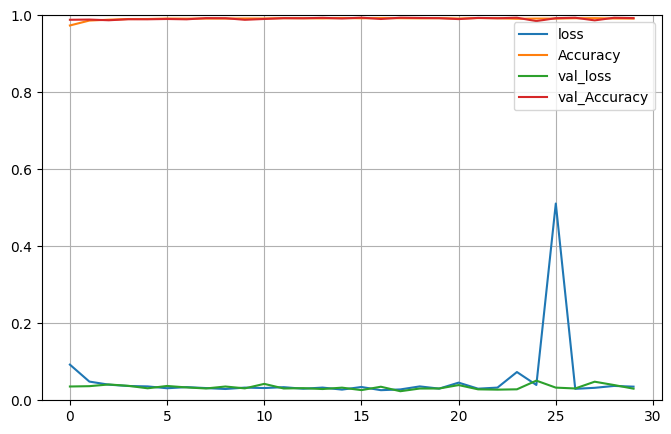

In [ ]:
pd.DataFrame(history_cnn.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

##**PCA15**

In [ ]:
pca15 = PCA(n_components=15)
pca15.fit(nsl_train_x_scaled)
nsl_pca15_train = pca15.transform(nsl_train_x_scaled)
nsl_pca15_val = pca15.transform(nsl_val_x_scaled)
nsl_pca15_test = pca15.transform(nsl_test_x_scaled)

scaler.fit(nsl_pca15_train)
nsl_pca15_train_scaled=scaler.transform(nsl_pca15_train)
nsl_pca15_val_scaled=scaler.transform(nsl_pca15_val)
nsl_pca15_test_scaled=scaler.transform(nsl_pca15_test)

###**SVM**

In [ ]:
start = time.time()

rbf15_kernel_svm_clf = OneVsRestClassifier(SVC(kernel="rbf", gamma=1, C=10))
rbf15_kernel_svm_clf.fit(nsl_pca15_train_scaled, nsl_train_y_one)

print("time :", time.time() - start)

time : 481.782190322876


In [ ]:
predict(rbf15_kernel_svm_clf, nsl_pca15_val_scaled, nsl_val_y_one)

time : 16.14681363105774
Accuracy: 0.995%


              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00     13469
         Dos       1.00      1.00      1.00      9186
       Probe       0.99      0.98      0.99      2331
         U2R       0.97      0.87      0.92       197
         R2L       0.57      0.33      0.42        12

   micro avg       1.00      1.00      1.00     25195
   macro avg       0.91      0.84      0.86     25195
weighted avg       1.00      1.00      1.00     25195
 samples avg       1.00      1.00      1.00     25195


roc auc value: 0.918%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [ ]:
predict(rbf15_kernel_svm_clf,nsl_pca15_test_scaled, nsl_test_y_one)

time : 16.202983379364014
Accuracy: 0.733%


              precision    recall  f1-score   support

      Normal       0.65      0.97      0.78      9710
         Dos       0.98      0.77      0.87      7460
       Probe       0.82      0.53      0.64      2421
         U2R       0.96      0.01      0.02      2749
         R2L       0.14      0.04      0.07       203

   micro avg       0.75      0.73      0.74     22543
   macro avg       0.71      0.47      0.47     22543
weighted avg       0.81      0.73      0.69     22543
 samples avg       0.73      0.73      0.73     22543


roc auc value: 0.691%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

###RF

In [ ]:
start=time.time()
rf15 = RandomForestClassifier(n_estimators=100, min_samples_split=20, min_samples_leaf=8, max_depth=12, n_jobs=-1)
rf15.fit(nsl_pca15_train_scaled, nsl_train_y_one)
print("time :", time.time() - start)

time : 41.65300917625427


In [ ]:
predict(rf15,nsl_pca15_val_scaled, nsl_val_y_one)

time : 0.7393698692321777
Accuracy: 0.994%


              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00     13469
         Dos       1.00      1.00      1.00      9186
       Probe       0.99      0.97      0.98      2331
         U2R       0.97      0.81      0.88       197
         R2L       0.67      0.17      0.27        12

   micro avg       0.99      0.99      0.99     25195
   macro avg       0.92      0.79      0.83     25195
weighted avg       0.99      0.99      0.99     25195
 samples avg       0.99      0.99      0.99     25195


roc auc value: 0.894%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
predict(rf15,nsl_pca15_test_scaled, nsl_test_y_one)

time : 0.6657557487487793
Accuracy: 0.740%


              precision    recall  f1-score   support

      Normal       0.67      0.94      0.78      9710
         Dos       0.97      0.81      0.88      7460
       Probe       0.88      0.61      0.72      2421
         U2R       1.00      0.01      0.01      2749
         R2L       0.00      0.00      0.00       203

   micro avg       0.77      0.74      0.76     22543
   macro avg       0.70      0.47      0.48     22543
weighted avg       0.83      0.74      0.71     22543
 samples avg       0.74      0.74      0.74     22543


roc auc value: 0.699%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

###KNN

In [ ]:
start = time.time()

knn15 = KNeighborsClassifier(n_neighbors=3)
knn15.fit(nsl_pca15_train_scaled, nsl_train_y_one)

print("time :", time.time() - start)

time : 0.3765690326690674


In [ ]:
predict(knn15,nsl_pca15_val_scaled, nsl_val_y_one)

time : 4.162251234054565
Accuracy: 0.996%


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     13469
         Dos       1.00      1.00      1.00      9186
       Probe       0.99      0.98      0.99      2331
         U2R       0.96      0.91      0.93       197
         R2L       0.46      0.50      0.48        12

   micro avg       1.00      1.00      1.00     25195
   macro avg       0.88      0.88      0.88     25195
weighted avg       1.00      1.00      1.00     25195
 samples avg       1.00      1.00      1.00     25195


roc auc value: 0.938%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
predict(knn15,nsl_pca15_test_scaled, nsl_test_y_one)

time : 4.148423194885254
Accuracy: 0.755%


              precision    recall  f1-score   support

      Normal       0.66      0.93      0.77      9710
         Dos       0.96      0.82      0.88      7460
       Probe       0.71      0.72      0.72      2421
         U2R       0.95      0.05      0.09      2749
         R2L       0.50      0.10      0.17       203

   micro avg       0.75      0.75      0.75     22543
   macro avg       0.76      0.52      0.53     22543
weighted avg       0.80      0.75      0.72     22543
 samples avg       0.75      0.75      0.75     22543


roc auc value: 0.722%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

###XGBoost

In [ ]:
start=time.time()

xgb15 = OneVsRestClassifier(XGBClassifier(gamma=2, max_depth=6, n_estimators=32, random_state=42))
xgb15.fit(nsl_pca15_train_scaled, nsl_train_y_one)

print("time :", time.time() - start)

time : 41.39785647392273


In [ ]:
predict(xgb15,nsl_pca15_val_scaled, nsl_val_y_one)

time : 0.14261412620544434
Accuracy: 0.990%


              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99     13469
         Dos       1.00      1.00      1.00      9186
       Probe       0.99      0.97      0.98      2331
         U2R       0.98      0.87      0.92       197
         R2L       0.60      0.25      0.35        12

   micro avg       0.99      0.99      0.99     25195
   macro avg       0.91      0.82      0.85     25195
weighted avg       0.99      0.99      0.99     25195
 samples avg       0.99      0.99      0.99     25195


roc auc value: 0.907%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [ ]:
predict(xgb15,nsl_pca15_test_scaled, nsl_test_y_one)

time : 0.13409924507141113
Accuracy: 0.719%


              precision    recall  f1-score   support

      Normal       0.65      0.94      0.77      9710
         Dos       0.96      0.76      0.85      7460
       Probe       0.87      0.65      0.74      2421
         U2R       0.97      0.07      0.13      2749
         R2L       0.53      0.04      0.08       203

   micro avg       0.76      0.73      0.74     22543
   macro avg       0.80      0.49      0.51     22543
weighted avg       0.82      0.73      0.71     22543
 samples avg       0.73      0.73      0.73     22543


roc auc value: 0.705%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]])

###**DNN**

In [ ]:
from keras.backend import dropout
dnn15 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(15,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),  
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(5, activation="softmax")
])
dnn15.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 15)                0         
                                                                 
 batch_normalization_6 (Batc  (None, 15)               60        
 hNormalization)                                                 
                                                                 
 dense_18 (Dense)            (None, 300)               4800      
                                                                 
 dropout_12 (Dropout)        (None, 300)               0         
                                                                 
 batch_normalization_7 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_19 (Dense)            (None, 100)              

In [ ]:
dnn15.compile(loss="categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
history_dnn15 = dnn15.fit(nsl_pca15_train_scaled, nsl_train_y_one, epochs=30,
                        validation_data=(nsl_pca15_val_scaled, nsl_val_y_one))

Epoch 1/30
3150/3150 [==============================] - 10s 3ms/step - loss: 0.1449 - accuracy: 0.9582 - val_loss: 0.0963 - val_accuracy: 0.9746
Epoch 2/30
3150/3150 [==============================] - 10s 3ms/step - loss: 0.0873 - accuracy: 0.9721 - val_loss: 0.0845 - val_accuracy: 0.9780
Epoch 3/30
3150/3150 [==============================] - 9s 3ms/step - loss: 0.0751 - accuracy: 0.9752 - val_loss: 0.0954 - val_accuracy: 0.9790
Epoch 4/30
3150/3150 [==============================] - 9s 3ms/step - loss: 0.0705 - accuracy: 0.9769 - val_loss: 0.0834 - val_accuracy: 0.9778
Epoch 5/30
3150/3150 [==============================] - 9s 3ms/step - loss: 0.0661 - accuracy: 0.9782 - val_loss: 0.0772 - val_accuracy: 0.9806
Epoch 6/30
3150/3150 [==============================] - 11s 4ms/step - loss: 0.0630 - accuracy: 0.9785 - val_loss: 0.0788 - val_accuracy: 0.9801
Epoch 7/30
3150/3150 [==============================] - 9s 3ms/step - loss: 0.0602 - accuracy: 0.9789 - val_loss: 0.1035 - val_accura

In [ ]:
dnn15.evaluate(nsl_pca15_test_scaled, nsl_test_y_one)

705/705 [==============================] - 1s 2ms/step - loss: 1.2960 - accuracy: 0.7592


[1.2959530353546143, 0.7592157125473022]

In [ ]:
predict_nn(dnn15, nsl_pca15_val_scaled, nsl_val_y_one)

788/788 [==============================] - 1s 1ms/step
time : 2.6875972747802734
              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98     13469
         Dos       0.99      1.00      0.99      9186
       Probe       0.98      0.95      0.96      2331
         U2R       0.34      0.36      0.35       197
         R2L       0.25      0.08      0.12        12

   micro avg       0.98      0.98      0.98     25195
   macro avg       0.71      0.67      0.68     25195
weighted avg       0.98      0.98      0.98     25195
 samples avg       0.98      0.98      0.98     25195

roc auc value: 0.833%




array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
predict_nn(dnn15, nsl_pca15_test_scaled, nsl_test_y_one)

705/705 [==============================] - 1s 2ms/step
time : 1.361020803451538
              precision    recall  f1-score   support

      Normal       0.67      0.93      0.78      9710
         Dos       0.92      0.85      0.88      7460
       Probe       0.85      0.68      0.76      2421
         U2R       0.60      0.01      0.02      2749
         R2L       0.83      0.07      0.14       203

   micro avg       0.76      0.76      0.76     22543
   macro avg       0.77      0.51      0.52     22543
weighted avg       0.76      0.76      0.71     22543
 samples avg       0.76      0.76      0.76     22543

roc auc value: 0.715%




array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

###**CNN**

In [ ]:
cnn15 = keras.models.Sequential([
    keras.layers.Conv1D(64, 7, activation='relu', padding='same', input_shape=[15, 1]),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation='softmax'),
])

In [ ]:
cnn15.compile(loss = "categorical_crossentropy",
              optimizer = "nadam",
              metrics=["Accuracy"]
              )

In [ ]:
start=time.time()
history_cnn = cnn15.fit(nsl_pca15_train_scaled, nsl_train_y_one, epochs=30,
                        validation_data=(nsl_pca15_val_scaled, nsl_val_y_one))
print("time :", time.time() - start)


Epoch 1/30
3150/3150 [==============================] - 115s 36ms/step - loss: 0.0890 - Accuracy: 0.9745 - val_loss: 0.0435 - val_Accuracy: 0.9857
Epoch 2/30
3150/3150 [==============================] - 113s 36ms/step - loss: 0.0489 - Accuracy: 0.9853 - val_loss: 0.0438 - val_Accuracy: 0.9846
Epoch 3/30
3150/3150 [==============================] - 112s 35ms/step - loss: 0.0447 - Accuracy: 0.9859 - val_loss: 0.0369 - val_Accuracy: 0.9885
Epoch 4/30
3150/3150 [==============================] - 112s 36ms/step - loss: 0.0427 - Accuracy: 0.9870 - val_loss: 0.0579 - val_Accuracy: 0.9860
Epoch 5/30
3150/3150 [==============================] - 112s 36ms/step - loss: 0.0400 - Accuracy: 0.9878 - val_loss: 0.0361 - val_Accuracy: 0.9888
Epoch 6/30
3150/3150 [==============================] - 110s 35ms/step - loss: 0.0379 - Accuracy: 0.9887 - val_loss: 0.0369 - val_Accuracy: 0.9886
Epoch 7/30
3150/3150 [==============================] - 113s 36ms/step - loss: 0.0457 - Accuracy: 0.9882 - val_loss: 0

In [ ]:
cnn15.evaluate(nsl_pca15_test_scaled, nsl_test_y_one)

705/705 [==============================] - 4s 5ms/step - loss: 3.5840 - Accuracy: 0.7358


[3.5840096473693848, 0.7358381748199463]

In [ ]:
predict_nn(cnn15, nsl_pca15_val_scaled, nsl_val_y_one)

788/788 [==============================] - 4s 5ms/step
time : 5.286743402481079
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99     13469
         Dos       1.00      1.00      1.00      9186
       Probe       0.98      0.98      0.98      2331
         U2R       0.74      0.75      0.75       197
         R2L       0.00      0.00      0.00        12

   micro avg       0.99      0.99      0.99     25195
   macro avg       0.74      0.74      0.74     25195
weighted avg       0.99      0.99      0.99     25195
 samples avg       0.99      0.99      0.99     25195

roc auc value: 0.871%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
predict_nn(cnn15, nsl_pca15_test_scaled, nsl_test_y_one)

705/705 [==============================] - 4s 5ms/step
time : 3.716768264770508
              precision    recall  f1-score   support

      Normal       0.65      0.92      0.76      9710
         Dos       0.89      0.76      0.82      7460
       Probe       0.82      0.71      0.76      2421
         U2R       0.97      0.10      0.18      2749
         R2L       0.00      0.00      0.00       203

   micro avg       0.74      0.74      0.74     22543
   macro avg       0.67      0.50      0.50     22543
weighted avg       0.78      0.74      0.70     22543
 samples avg       0.74      0.74      0.74     22543

roc auc value: 0.704%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

##**PCA7**

In [ ]:
pca7 = PCA(n_components=7)
pca7.fit(nsl_train_x_scaled)
nsl_pca7_train = pca7.transform(nsl_train_x_scaled)
nsl_pca7_val = pca7.transform(nsl_val_x_scaled)
nsl_pca7_test = pca7.transform(nsl_test_x_scaled)

scaler.fit(nsl_pca7_train)
nsl_pca7_train_scaled=scaler.transform(nsl_pca7_train)
nsl_pca7_val_scaled=scaler.transform(nsl_pca7_val)
nsl_pca7_test_scaled=scaler.transform(nsl_pca7_test)

###**SVM**

In [ ]:
start = time.time()

rbf7_kernel_svm_clf = OneVsRestClassifier(SVC(kernel="rbf", gamma=1, C=10))
rbf7_kernel_svm_clf.fit(nsl_pca7_train_scaled, nsl_train_y_one)

print("time :", time.time() - start)

time : 43.3501250743866


In [ ]:
predict(rbf7_kernel_svm_clf, nsl_pca7_val_scaled, nsl_val_y_one)

time : 7.4493513107299805
Accuracy: 0.994%


              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99     13469
         Dos       1.00      1.00      1.00      9186
       Probe       0.99      0.98      0.98      2331
         U2R       0.93      0.85      0.89       197
         R2L       0.67      0.33      0.44        12

   micro avg       0.99      0.99      0.99     25195
   macro avg       0.92      0.83      0.86     25195
weighted avg       0.99      0.99      0.99     25195
 samples avg       0.99      0.99      0.99     25195


roc auc value: 0.915%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [ ]:
predict(rbf7_kernel_svm_clf, nsl_pca7_test_scaled, nsl_test_y_one)

time : 6.627949237823486
Accuracy: 0.742%


              precision    recall  f1-score   support

      Normal       0.68      0.97      0.80      9710
         Dos       0.90      0.76      0.82      7460
       Probe       0.70      0.53      0.60      2421
         U2R       0.99      0.15      0.26      2749
         R2L       0.31      0.02      0.05       203

   micro avg       0.75      0.75      0.75     22543
   macro avg       0.72      0.49      0.51     22543
weighted avg       0.79      0.75      0.71     22543
 samples avg       0.74      0.75      0.74     22543


roc auc value: 0.701%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0]])

###RF

In [ ]:
start = time.time()
rf7 = RandomForestClassifier(n_estimators=100, min_samples_split=20, min_samples_leaf=8, max_depth=12, n_jobs=-1)
rf7.fit(nsl_pca7_train_scaled, nsl_train_y_one)
print("time :", time.time() - start)

time : 32.2009379863739


In [ ]:
predict(rf7, nsl_pca7_val_scaled, nsl_val_y_one)

time : 1.7972912788391113
Accuracy: 0.992%


              precision    recall  f1-score   support

      Normal       0.99      1.00      0.99     13469
         Dos       1.00      1.00      1.00      9186
       Probe       0.99      0.97      0.98      2331
         U2R       0.97      0.76      0.85       197
         R2L       1.00      0.08      0.15        12

   micro avg       0.99      0.99      0.99     25195
   macro avg       0.99      0.76      0.80     25195
weighted avg       0.99      0.99      0.99     25195
 samples avg       0.99      0.99      0.99     25195


roc auc value: 0.880%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
predict(rf7, nsl_pca7_test_scaled, nsl_test_y_one)

time : 1.297471523284912
Accuracy: 0.724%


              precision    recall  f1-score   support

      Normal       0.65      0.98      0.78      9710
         Dos       0.94      0.75      0.84      7460
       Probe       0.88      0.50      0.64      2421
         U2R       1.00      0.00      0.00      2749
         R2L       0.00      0.00      0.00       203

   micro avg       0.74      0.72      0.73     22543
   macro avg       0.70      0.45      0.45     22543
weighted avg       0.81      0.72      0.68     22543
 samples avg       0.72      0.72      0.72     22543


roc auc value: 0.680%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

###KNN

In [ ]:
start = time.time()

knn7 = KNeighborsClassifier(n_neighbors=3)
knn7.fit(nsl_pca7_train_scaled, nsl_train_y_one)

print("time :", time.time() - start)

time : 1.2138071060180664


In [ ]:
predict(knn7, nsl_pca7_val_scaled, nsl_val_y_one)

time : 8.716289758682251
Accuracy: 0.996%


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     13469
         Dos       1.00      1.00      1.00      9186
       Probe       0.99      0.99      0.99      2331
         U2R       0.94      0.92      0.93       197
         R2L       0.67      0.50      0.57        12

   micro avg       1.00      1.00      1.00     25195
   macro avg       0.92      0.88      0.90     25195
weighted avg       1.00      1.00      1.00     25195
 samples avg       1.00      1.00      1.00     25195


roc auc value: 0.939%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
predict(knn7, nsl_pca7_test_scaled, nsl_test_y_one)

time : 3.330554962158203
Accuracy: 0.756%


              precision    recall  f1-score   support

      Normal       0.68      0.98      0.80      9710
         Dos       0.91      0.80      0.85      7460
       Probe       0.73      0.48      0.58      2421
         U2R       0.98      0.16      0.27      2749
         R2L       0.35      0.06      0.11       203

   micro avg       0.76      0.76      0.76     22543
   macro avg       0.73      0.50      0.52     22543
weighted avg       0.80      0.76      0.72     22543
 samples avg       0.76      0.76      0.76     22543


roc auc value: 0.707%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

###XGBoost

In [ ]:
start=time.time()

xgb7 = OneVsRestClassifier(XGBClassifier(gamma=2, max_depth=6, n_estimators=32, random_state=42))
xgb7.fit(nsl_pca7_train_scaled, nsl_train_y_one)

print("time :", time.time() - start)

time : 23.069157600402832


In [ ]:
predict(xgb7, nsl_pca7_val_scaled, nsl_val_y_one)

time : 0.11263847351074219
Accuracy: 0.986%


              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99     13469
         Dos       1.00      1.00      1.00      9186
       Probe       0.99      0.96      0.97      2331
         U2R       0.94      0.85      0.89       197
         R2L       0.43      0.25      0.32        12

   micro avg       0.99      0.99      0.99     25195
   macro avg       0.87      0.81      0.83     25195
weighted avg       0.99      0.99      0.99     25195
 samples avg       0.99      0.99      0.99     25195


roc auc value: 0.903%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [ ]:
predict(xgb7, nsl_pca7_test_scaled, nsl_test_y_one)

time : 0.11694526672363281
Accuracy: 0.716%


              precision    recall  f1-score   support

      Normal       0.66      0.97      0.78      9710
         Dos       0.93      0.77      0.84      7460
       Probe       0.85      0.51      0.64      2421
         U2R       0.93      0.01      0.03      2749
         R2L       0.57      0.04      0.07       203

   micro avg       0.75      0.73      0.74     22543
   macro avg       0.79      0.46      0.47     22543
weighted avg       0.80      0.73      0.69     22543
 samples avg       0.72      0.73      0.73     22543


roc auc value: 0.687%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [1, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0]])

###DNN

In [ ]:
from keras.backend import dropout
dnn7 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(7,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),  
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(5, activation="softmax")
])
dnn7.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 7)                 0         
                                                                 
 batch_normalization_9 (Batc  (None, 7)                28        
 hNormalization)                                                 
                                                                 
 dense_24 (Dense)            (None, 300)               2400      
                                                                 
 dropout_16 (Dropout)        (None, 300)               0         
                                                                 
 batch_normalization_10 (Bat  (None, 300)              1200      
 chNormalization)                                                
                                                                 
 dense_25 (Dense)            (None, 100)              

In [ ]:
dnn7.compile(loss="categorical_crossentropy",
            optimizer="sgd",
            metrics=["accuracy"])

In [ ]:
history_dnn7 = dnn7.fit(nsl_pca7_train_scaled, nsl_train_y_one, epochs=30,
                        validation_data=(nsl_pca7_val_scaled, nsl_val_y_one))

Epoch 1/30
3150/3150 [==============================] - 24s 7ms/step - loss: 0.1912 - accuracy: 0.9420 - val_loss: 0.1104 - val_accuracy: 0.9643
Epoch 2/30
3150/3150 [==============================] - 17s 5ms/step - loss: 0.1277 - accuracy: 0.9572 - val_loss: 0.1142 - val_accuracy: 0.9664
Epoch 3/30
3150/3150 [==============================] - 17s 5ms/step - loss: 0.1126 - accuracy: 0.9601 - val_loss: 0.1004 - val_accuracy: 0.9723
Epoch 4/30
3150/3150 [==============================] - 10s 3ms/step - loss: 0.1045 - accuracy: 0.9623 - val_loss: 0.1137 - val_accuracy: 0.9696
Epoch 5/30
3150/3150 [==============================] - 9s 3ms/step - loss: 0.0999 - accuracy: 0.9642 - val_loss: 0.1132 - val_accuracy: 0.9713
Epoch 6/30
3150/3150 [==============================] - 9s 3ms/step - loss: 0.0935 - accuracy: 0.9656 - val_loss: 0.1281 - val_accuracy: 0.9692
Epoch 7/30
3150/3150 [==============================] - 9s 3ms/step - loss: 0.0924 - accuracy: 0.9661 - val_loss: 0.1001 - val_accur

In [ ]:
mlp7.evaluate(nsl_pca7_test_scaled, nsl_test_y_one)

705/705 [==============================] - 1s 2ms/step - loss: 1.2113 - accuracy: 0.7636


[1.2113068103790283, 0.7636073231697083]

In [ ]:
predict_nn(mlp7, nsl_pca7_val_scaled, nsl_val_y_one)

788/788 [==============================] - 2s 3ms/step
time : 3.0686898231506348
              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98     13469
         Dos       0.99      1.00      1.00      9186
       Probe       0.93      0.96      0.95      2331
         U2R       0.49      0.73      0.59       197
         R2L       0.11      0.50      0.18        12

   micro avg       0.98      0.98      0.98     25195
   macro avg       0.70      0.83      0.74     25195
weighted avg       0.98      0.98      0.98     25195
 samples avg       0.98      0.98      0.98     25195

roc auc value: 0.912%




array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
predict_nn(mlp7, nsl_pca7_test_scaled, nsl_test_y_one)

705/705 [==============================] - 2s 3ms/step
time : 5.200573921203613
              precision    recall  f1-score   support

      Normal       0.67      0.97      0.79      9710
         Dos       0.94      0.84      0.89      7460
       Probe       0.85      0.61      0.71      2421
         U2R       0.50      0.00      0.01      2749
         R2L       0.52      0.15      0.23       203

   micro avg       0.76      0.76      0.76     22543
   macro avg       0.70      0.52      0.53     22543
weighted avg       0.76      0.76      0.71     22543
 samples avg       0.76      0.76      0.76     22543

roc auc value: 0.717%




array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

###**CNN**

In [ ]:
cnn7 = keras.models.Sequential([
    keras.layers.Conv1D(64, 7, activation='relu', padding='same', input_shape=[7, 1]),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation='softmax'),
])

In [ ]:
cnn7.compile(loss = "categorical_crossentropy",
            optimizer = "nadam",
            metrics=["Accuracy"]
            )

In [ ]:
start=time.time()
history_cnn = cnn7.fit(nsl_pca7_train_scaled, nsl_train_y_one, epochs=30,
                        validation_data=(nsl_pca7_val_scaled, nsl_val_y_one))
print("time :", time.time() - start)


Epoch 1/30
3150/3150 [==============================] - 43s 13ms/step - loss: 0.1043 - Accuracy: 0.9675 - val_loss: 0.0554 - val_Accuracy: 0.9812
Epoch 2/30
3150/3150 [==============================] - 32s 10ms/step - loss: 0.0588 - Accuracy: 0.9804 - val_loss: 0.0593 - val_Accuracy: 0.9802
Epoch 3/30
3150/3150 [==============================] - 21s 7ms/step - loss: 0.0516 - Accuracy: 0.9829 - val_loss: 0.0434 - val_Accuracy: 0.9852
Epoch 4/30
3150/3150 [==============================] - 20s 7ms/step - loss: 0.0457 - Accuracy: 0.9854 - val_loss: 0.0397 - val_Accuracy: 0.9869
Epoch 5/30
3150/3150 [==============================] - 21s 7ms/step - loss: 0.0412 - Accuracy: 0.9866 - val_loss: 0.0363 - val_Accuracy: 0.9883
Epoch 6/30
3150/3150 [==============================] - 21s 7ms/step - loss: 0.0387 - Accuracy: 0.9877 - val_loss: 0.0379 - val_Accuracy: 0.9863
Epoch 7/30
3150/3150 [==============================] - 20s 6ms/step - loss: 0.0362 - Accuracy: 0.9883 - val_loss: 0.0584 - val_

In [ ]:
cnn7.evaluate(nsl_pca7_test_scaled, nsl_test_y_one)

705/705 [==============================] - 3s 3ms/step - loss: 4.6456 - Accuracy: 0.7515


[4.645587921142578, 0.7514528036117554]

In [ ]:
predict_nn(cnn7, nsl_pca7_val_scaled, nsl_val_y_one)

788/788 [==============================] - 2s 2ms/step
time : 2.0810964107513428
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99     13469
         Dos       1.00      1.00      1.00      9186
       Probe       0.98      0.98      0.98      2331
         U2R       0.58      0.83      0.68       197
         R2L       0.00      0.00      0.00        12

   micro avg       0.99      0.99      0.99     25195
   macro avg       0.71      0.76      0.73     25195
weighted avg       0.99      0.99      0.99     25195
 samples avg       0.99      0.99      0.99     25195

roc auc value: 0.878%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
predict_nn(cnn7, nsl_pca7_test_scaled, nsl_test_y_one)

705/705 [==============================] - 2s 2ms/step
time : 2.6064505577087402
              precision    recall  f1-score   support

      Normal       0.66      0.98      0.79      9710
         Dos       0.94      0.81      0.87      7460
       Probe       0.84      0.52      0.64      2421
         U2R       0.94      0.04      0.08      2749
         R2L       0.00      0.00      0.00       203

   micro avg       0.75      0.75      0.75     22543
   macro avg       0.68      0.47      0.48     22543
weighted avg       0.80      0.75      0.71     22543
 samples avg       0.75      0.75      0.75     22543

roc auc value: 0.693%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

##**PCA2**

In [ ]:
pca2 = PCA(n_components=2)
pca2.fit(nsl_train_x_scaled)
nsl_pca2_train = pca2.transform(nsl_train_x_scaled)
nsl_pca2_val = pca2.transform(nsl_val_x_scaled)
nsl_pca2_test = pca2.transform(nsl_test_x_scaled)

scaler.fit(nsl_pca2_train)
nsl_pca2_train_scaled=scaler.transform(nsl_pca2_train)
nsl_pca2_val_scaled=scaler.transform(nsl_pca2_val)
nsl_pca2_test_scaled=scaler.transform(nsl_pca2_test)

###**SVM**

In [ ]:
start = time.time()

rbf2_kernel_svm_clf = OneVsRestClassifier(SVC(kernel="rbf", gamma=1, C=10))
rbf2_kernel_svm_clf.fit(nsl_pca2_train_scaled, nsl_train_y_one)

print("time :", time.time() - start)

time : 456.0698301792145


In [ ]:
predict(rbf2_kernel_svm_clf, nsl_pca2_val_scaled, nsl_val_y_one)

time : 42.9310519695282
Accuracy: 0.928%


              precision    recall  f1-score   support

      Normal       0.90      1.00      0.94     13469
         Dos       0.99      0.89      0.94      9186
       Probe       0.96      0.78      0.86      2331
         U2R       0.00      0.00      0.00       197
         R2L       0.00      0.00      0.00        12

   micro avg       0.93      0.93      0.93     25195
   macro avg       0.57      0.53      0.55     25195
weighted avg       0.93      0.93      0.93     25195
 samples avg       0.93      0.93      0.93     25195


roc auc value: 0.753%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [ ]:
predict(rbf2_kernel_svm_clf, nsl_pca2_test_scaled, nsl_test_y_one)

time : 40.66684818267822
Accuracy: 0.691%


              precision    recall  f1-score   support

      Normal       0.62      0.98      0.76      9710
         Dos       0.95      0.61      0.74      7460
       Probe       0.76      0.65      0.70      2421
         U2R       0.00      0.00      0.00      2749
         R2L       0.00      0.00      0.00       203

   micro avg       0.70      0.70      0.70     22543
   macro avg       0.47      0.45      0.44     22543
weighted avg       0.66      0.70      0.65     22543
 samples avg       0.69      0.70      0.69     22543


roc auc value: 0.674%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0]])

###RF

In [ ]:
start = time.time()
rf2 = RandomForestClassifier(n_estimators=100, min_samples_split=20, min_samples_leaf=8, max_depth=12, n_jobs=-1)
rf2.fit(nsl_pca2_train_scaled, nsl_train_y_one)
print("time :", time.time() - start)

time : 16.88367509841919


In [ ]:
predict(rf2, nsl_pca2_val_scaled, nsl_val_y_one)

time : 0.7039592266082764
Accuracy: 0.945%


              precision    recall  f1-score   support

      Normal       0.93      0.99      0.96     13469
         Dos       0.99      0.93      0.95      9186
       Probe       0.98      0.83      0.90      2331
         U2R       0.80      0.45      0.58       197
         R2L       0.00      0.00      0.00        12

   micro avg       0.95      0.95      0.95     25195
   macro avg       0.74      0.64      0.68     25195
weighted avg       0.95      0.95      0.95     25195
 samples avg       0.95      0.95      0.95     25195


roc auc value: 0.810%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
predict(rf2, nsl_pca2_test_scaled, nsl_test_y_one)

time : 0.6487033367156982
Accuracy: 0.712%


              precision    recall  f1-score   support

      Normal       0.64      0.98      0.77      9710
         Dos       0.94      0.67      0.78      7460
       Probe       0.78      0.65      0.71      2421
         U2R       0.20      0.00      0.00      2749
         R2L       0.00      0.00      0.00       203

   micro avg       0.73      0.71      0.72     22543
   macro avg       0.51      0.46      0.45     22543
weighted avg       0.69      0.71      0.67     22543
 samples avg       0.71      0.71      0.71     22543


roc auc value: 0.684%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

###KNN

In [ ]:
start = time.time()

knn2 = KNeighborsClassifier(n_neighbors=3)
knn2.fit(nsl_pca2_train_scaled, nsl_train_y_one)

print("time :", time.time() - start)

time : 0.10317802429199219


In [ ]:
predict(knn2, nsl_pca2_val_scaled, nsl_val_y_one)

time : 3.56306791305542
Accuracy: 0.960%


              precision    recall  f1-score   support

      Normal       0.97      0.96      0.97     13469
         Dos       0.96      0.97      0.96      9186
       Probe       0.95      0.93      0.94      2331
         U2R       0.76      0.76      0.76       197
         R2L       1.00      0.08      0.15        12

   micro avg       0.96      0.96      0.96     25195
   macro avg       0.93      0.74      0.76     25195
weighted avg       0.96      0.96      0.96     25195
 samples avg       0.96      0.96      0.96     25195


roc auc value: 0.864%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
predict(knn2, nsl_pca2_test_scaled, nsl_test_y_one)

time : 3.129725456237793
Accuracy: 0.716%


              precision    recall  f1-score   support

      Normal       0.66      0.95      0.78      9710
         Dos       0.85      0.70      0.77      7460
       Probe       0.73      0.67      0.70      2421
         U2R       0.70      0.04      0.08      2749
         R2L       0.00      0.00      0.00       203

   micro avg       0.72      0.72      0.72     22543
   macro avg       0.59      0.47      0.46     22543
weighted avg       0.73      0.72      0.67     22543
 samples avg       0.72      0.72      0.72     22543


roc auc value: 0.690%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

###XGBoost

In [ ]:
start=time.time()

xgb2 = OneVsRestClassifier(XGBClassifier(gamma=2, max_depth=6, n_estimators=32, random_state=42))
xgb2.fit(nsl_pca2_train_scaled, nsl_train_y_one)

print("time :", time.time() - start)

time : 8.449647426605225


In [ ]:
predict(xgb2, nsl_pca2_val_scaled, nsl_val_y_one)

time : 0.09898209571838379
Accuracy: 0.929%


              precision    recall  f1-score   support

      Normal       0.90      0.99      0.95     13469
         Dos       0.98      0.91      0.94      9186
       Probe       0.97      0.81      0.88      2331
         U2R       0.73      0.50      0.59       197
         R2L       0.00      0.00      0.00        12

   micro avg       0.94      0.94      0.94     25195
   macro avg       0.72      0.64      0.67     25195
weighted avg       0.94      0.94      0.94     25195
 samples avg       0.93      0.94      0.94     25195


roc auc value: 0.807%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [ ]:
predict(xgb2, nsl_pca2_test_scaled, nsl_test_y_one)

time : 0.10176491737365723
Accuracy: 0.701%


              precision    recall  f1-score   support

      Normal       0.62      0.98      0.76      9710
         Dos       0.94      0.64      0.76      7460
       Probe       0.80      0.71      0.75      2421
         U2R       0.09      0.00      0.00      2749
         R2L       0.00      0.00      0.00       203

   micro avg       0.71      0.71      0.71     22543
   macro avg       0.49      0.47      0.46     22543
weighted avg       0.68      0.71      0.66     22543
 samples avg       0.71      0.71      0.71     22543


roc auc value: 0.684%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0]])

###DNN

In [ ]:
from keras.backend import dropout
dnn2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(2,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),  
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(5, activation="softmax")
])
dnn2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 2)                 0         
                                                                 
 batch_normalization_12 (Bat  (None, 2)                8         
 chNormalization)                                                
                                                                 
 dense_29 (Dense)            (None, 300)               900       
                                                                 
 dropout_19 (Dropout)        (None, 300)               0         
                                                                 
 batch_normalization_13 (Bat  (None, 300)              1200      
 chNormalization)                                                
                                                                 
 dense_30 (Dense)            (None, 100)             

In [ ]:
dnn2.compile(loss="categorical_crossentropy",
            optimizer="sgd",
            metrics=["accuracy"])

In [ ]:
history_dnn2 = dnn2.fit(nsl_pca2_train_scaled, nsl_train_y_one, epochs=30,
                        validation_data=(nsl_pca2_val_scaled, nsl_val_y_one))

Epoch 1/30
3150/3150 [==============================] - 10s 3ms/step - loss: 0.3728 - accuracy: 0.8780 - val_loss: 0.2716 - val_accuracy: 0.9049
Epoch 2/30
3150/3150 [==============================] - 9s 3ms/step - loss: 0.3038 - accuracy: 0.8993 - val_loss: 0.2464 - val_accuracy: 0.9186
Epoch 3/30
3150/3150 [==============================] - 9s 3ms/step - loss: 0.2851 - accuracy: 0.9068 - val_loss: 0.2310 - val_accuracy: 0.9244
Epoch 4/30
3150/3150 [==============================] - 9s 3ms/step - loss: 0.2756 - accuracy: 0.9101 - val_loss: 0.2306 - val_accuracy: 0.9247
Epoch 5/30
3150/3150 [==============================] - 9s 3ms/step - loss: 0.2716 - accuracy: 0.9116 - val_loss: 0.2383 - val_accuracy: 0.9165
Epoch 6/30
3150/3150 [==============================] - 9s 3ms/step - loss: 0.2646 - accuracy: 0.9142 - val_loss: 0.2244 - val_accuracy: 0.9234
Epoch 7/30
3150/3150 [==============================] - 9s 3ms/step - loss: 0.2640 - accuracy: 0.9137 - val_loss: 0.2287 - val_accuracy

In [ ]:
dnn2.evaluate(nsl_pca2_test_scaled, nsl_test_y_one)

705/705 [==============================] - 1s 2ms/step - loss: 1.0676 - accuracy: 0.6935


[1.0675644874572754, 0.6935190558433533]

In [ ]:
predict_nn(dnn2, nsl_pca2_val_scaled, nsl_val_y_one)

788/788 [==============================] - 1s 1ms/step
time : 1.453606128692627
              precision    recall  f1-score   support

      Normal       0.89      1.00      0.94     13469
         Dos       0.97      0.89      0.93      9186
       Probe       0.97      0.72      0.83      2331
         U2R       0.00      0.00      0.00       197
         R2L       0.00      0.00      0.00        12

   micro avg       0.92      0.92      0.92     25195
   macro avg       0.57      0.52      0.54     25195
weighted avg       0.92      0.92      0.92     25195
 samples avg       0.92      0.92      0.92     25195

roc auc value: 0.745%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
predict_nn(dnn2, nsl_pca2_test_scaled, nsl_test_y_one)

705/705 [==============================] - 1s 2ms/step
time : 1.3135926723480225
              precision    recall  f1-score   support

      Normal       0.61      0.99      0.76      9710
         Dos       0.91      0.62      0.74      7460
       Probe       0.82      0.57      0.67      2421
         U2R       0.00      0.00      0.00      2749
         R2L       0.00      0.00      0.00       203

   micro avg       0.69      0.69      0.69     22543
   macro avg       0.47      0.44      0.43     22543
weighted avg       0.65      0.69      0.64     22543
 samples avg       0.69      0.69      0.69     22543

roc auc value: 0.666%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

###**CNN**

In [ ]:
cnn2 = keras.models.Sequential([
    keras.layers.Conv1D(64, 7, activation='relu', padding='same', input_shape=[2, 1]),
    keras.layers.MaxPooling1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation='softmax'),
])

In [ ]:
cnn2.compile(loss = "categorical_crossentropy",
            optimizer = "nadam",
            metrics=["Accuracy"]
            )

In [ ]:
start=time.time()
history_cnn = cnn2.fit(nsl_pca2_train_scaled, nsl_train_y_one, epochs=30,
                        validation_data=(nsl_pca2_val_scaled, nsl_val_y_one))
print("time :", time.time() - start)


Epoch 1/30
3150/3150 [==============================] - 9s 2ms/step - loss: 0.3455 - Accuracy: 0.8979 - val_loss: 0.2580 - val_Accuracy: 0.9222
Epoch 2/30
3150/3150 [==============================] - 7s 2ms/step - loss: 0.2516 - Accuracy: 0.9240 - val_loss: 0.2256 - val_Accuracy: 0.9241
Epoch 3/30
3150/3150 [==============================] - 7s 2ms/step - loss: 0.2264 - Accuracy: 0.9275 - val_loss: 0.2098 - val_Accuracy: 0.9284
Epoch 4/30
3150/3150 [==============================] - 7s 2ms/step - loss: 0.2153 - Accuracy: 0.9292 - val_loss: 0.2032 - val_Accuracy: 0.9299
Epoch 5/30
3150/3150 [==============================] - 7s 2ms/step - loss: 0.2108 - Accuracy: 0.9295 - val_loss: 0.2026 - val_Accuracy: 0.9295
Epoch 6/30
3150/3150 [==============================] - 7s 2ms/step - loss: 0.2067 - Accuracy: 0.9300 - val_loss: 0.1985 - val_Accuracy: 0.9301
Epoch 7/30
3150/3150 [==============================] - 7s 2ms/step - loss: 0.2031 - Accuracy: 0.9300 - val_loss: 0.1964 - val_Accuracy:

In [ ]:
cnn2.evaluate(nsl_pca2_test_scaled, nsl_test_y_one)

705/705 [==============================] - 1s 2ms/step - loss: 1.5046 - Accuracy: 0.6918


[1.5045701265335083, 0.6917890310287476]

In [ ]:
predict_nn(cnn2, nsl_pca2_val_scaled, nsl_val_y_one)

788/788 [==============================] - 1s 1ms/step
time : 1.3108794689178467
              precision    recall  f1-score   support

      Normal       0.89      1.00      0.94     13469
         Dos       0.99      0.89      0.94      9186
       Probe       0.96      0.79      0.87      2331
         U2R       0.00      0.00      0.00       197
         R2L       0.00      0.00      0.00        12

   micro avg       0.93      0.93      0.93     25195
   macro avg       0.57      0.54      0.55     25195
weighted avg       0.93      0.93      0.93     25195
 samples avg       0.93      0.93      0.93     25195

roc auc value: 0.754%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
predict_nn(cnn2, nsl_pca2_test_scaled, nsl_test_y_one)

705/705 [==============================] - 1s 1ms/step
time : 1.1904511451721191
              precision    recall  f1-score   support

      Normal       0.61      0.99      0.75      9710
         Dos       0.94      0.61      0.74      7460
       Probe       0.78      0.60      0.67      2421
         U2R       0.00      0.00      0.00      2749
         R2L       0.00      0.00      0.00       203

   micro avg       0.69      0.69      0.69     22543
   macro avg       0.46      0.44      0.43     22543
weighted avg       0.66      0.69      0.64     22543
 samples avg       0.69      0.69      0.69     22543

roc auc value: 0.667%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

# **SMOTE**

In [ ]:
smote = SMOTE(random_state=42)

nsl_train_x_over, nsl_train_y_over = smote.fit_resample(nsl_train_x_scaled, nsl_train_y)
print("Before SMOTE : ", nsl_train_x.shape, nsl_train_y.shape)
print("After SMOTE :", nsl_train_x_over.shape, nsl_train_y_over.shape)


Before SMOTE :  (100778, 59) (100778,)
After SMOTE : (269370, 59) (269370,)


In [ ]:
nsl_train_y.value_counts()

0    53874
1    36741
2     9325
3      790
4       48
Name: attack_cat, dtype: int64

In [ ]:
nsl_train_y_over.value_counts()

0    53874
1    53874
2    53874
3    53874
4    53874
Name: attack_cat, dtype: int64

Text(0, 0.5, 'Number of Records')

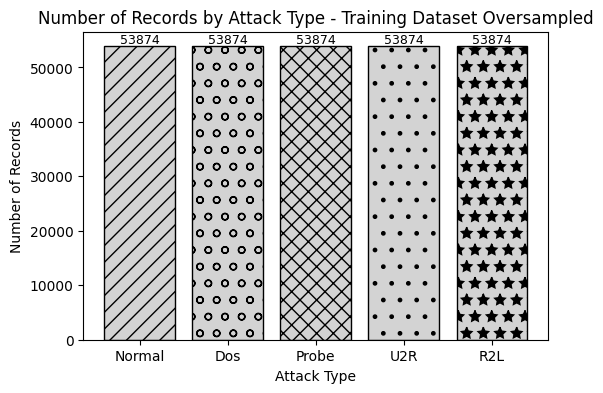

In [ ]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 10

x = ["Normal", "Dos", "Probe", "U2R", "R2L"]
y = nsl_train_y_over.value_counts()

plt.bar(x, y)

bars = plt.bar(x, y, color='lightgray', edgecolor='black')
bars[0].set_hatch('//')
bars[1].set_hatch('o')
bars[2].set_hatch('XX')
bars[3].set_hatch('.')
bars[4].set_hatch('*')

for i, v in enumerate(x):
    plt.text(v, y[i], y[i],
            fontsize=9,
            color='black',
            horizontalalignment='center',
            verticalalignment='bottom')

plt.title("Number of Records by Attack Type - Training Dataset Oversampled")
plt.xlabel("Attack Type")
plt.ylabel("Number of Records")


In [ ]:
nsl_train_y_over_one = tf.keras.utils.to_categorical(nsl_train_y_over)

## **Baseline(NONE)**

###**SVM**

In [ ]:
start = time.time()

svm_ov= OneVsRestClassifier(SVC(kernel="rbf", gamma=1, C=10))
svm_ov.fit(nsl_train_x_over, nsl_train_y_over_one)

print("time :", time.time() - start)

In [ ]:
predict(svm_ov, nsl_val_x_scaled, nsl_val_y_one)

In [ ]:
predict(svm_ov, nsl_test_x_scaled, nsl_test_y_one)

###**RF**

In [ ]:
start = time.time()
rf_over = RandomForestClassifier(n_estimators=100, min_samples_split=20, min_samples_leaf=8, max_depth=12, n_jobs=-1)
rf_over.fit(nsl_train_x_over, nsl_train_y_over_one)
print("time :", time.time() - start)

time : 64.69114279747009


In [ ]:
predict(rf_over, nsl_val_x_scaled, nsl_val_y_one)

time : 0.8133814334869385
Accuracy: 0.994%


              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00     13469
         Dos       1.00      1.00      1.00      9186
       Probe       1.00      0.99      0.99      2331
         U2R       0.86      0.97      0.91       197
         R2L       0.29      0.67      0.40        12

   micro avg       1.00      0.99      1.00     25195
   macro avg       0.83      0.92      0.86     25195
weighted avg       1.00      0.99      1.00     25195
 samples avg       0.99      0.99      0.99     25195


roc auc value: 0.961%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
predict(rf_over, nsl_test_x_scaled, nsl_test_y_one)

time : 0.8312640190124512
Accuracy: 0.741%


              precision    recall  f1-score   support

      Normal       0.69      0.97      0.81      9710
         Dos       0.96      0.75      0.84      7460
       Probe       0.85      0.62      0.72      2421
         U2R       0.98      0.06      0.12      2749
         R2L       0.32      0.06      0.10       203

   micro avg       0.78      0.74      0.76     22543
   macro avg       0.76      0.49      0.52     22543
weighted avg       0.83      0.74      0.72     22543
 samples avg       0.74      0.74      0.74     22543


roc auc value: 0.711%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]], dtype=float32)

###**KNN**

In [ ]:
start = time.time()

knn_over = KNeighborsClassifier(n_neighbors=3)
knn_over.fit(nsl_train_x_over, nsl_train_y_over_one)

print("time :", time.time() - start)

time : 0.11927556991577148


In [ ]:
predict(knn_over, nsl_val_x_scaled, nsl_val_y_one)

time : 131.41034841537476
Accuracy: 0.997%


              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     13469
         Dos       1.00      1.00      1.00      9186
       Probe       0.99      1.00      0.99      2331
         U2R       0.86      0.97      0.91       197
         R2L       0.47      0.67      0.55        12

   micro avg       1.00      1.00      1.00     25195
   macro avg       0.86      0.93      0.89     25195
weighted avg       1.00      1.00      1.00     25195
 samples avg       1.00      1.00      1.00     25195


roc auc value: 0.962%




array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
predict(knn_over, nsl_test_x_scaled, nsl_test_y_one)

time : 113.18818593025208
Accuracy: 0.771%


              precision    recall  f1-score   support

      Normal       0.68      0.96      0.80      9710
         Dos       0.96      0.81      0.88      7460
       Probe       0.83      0.76      0.79      2421
         U2R       0.90      0.04      0.08      2749
         R2L       0.16      0.16      0.16       203

   micro avg       0.77      0.77      0.77     22543
   macro avg       0.71      0.55      0.54     22543
weighted avg       0.81      0.77      0.73     22543
 samples avg       0.77      0.77      0.77     22543


roc auc value: 0.736%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

###**XGBoost**

In [ ]:
start=time.time()
xgb_over = OneVsRestClassifier(XGBClassifier(gamma=2, max_depth=6, n_estimators=32, random_state=42))
xgb_over.fit(nsl_train_x_over, nsl_train_y_over_one)
print("time :", time.time() - start)

time : 155.6721601486206


In [ ]:
predict(xgb_over, nsl_val_x_scaled, nsl_val_y_one)

time : 0.24292969703674316
Accuracy: 0.976%


              precision    recall  f1-score   support

      Normal       1.00      0.96      0.98     13469
         Dos       1.00      1.00      1.00      9186
       Probe       0.99      0.99      0.99      2331
         U2R       0.71      0.98      0.82       197
         R2L       0.26      0.67      0.37        12

   micro avg       0.99      0.98      0.99     25195
   macro avg       0.79      0.92      0.83     25195
weighted avg       1.00      0.98      0.99     25195
 samples avg       0.98      0.98      0.98     25195


roc auc value: 0.959%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [ ]:
predict(xgb_over, nsl_test_x_scaled, nsl_test_y_one)

time : 0.22823238372802734
Accuracy: 0.765%


              precision    recall  f1-score   support

      Normal       0.77      0.96      0.85      9710
         Dos       0.96      0.79      0.87      7460
       Probe       0.82      0.76      0.79      2421
         U2R       0.82      0.22      0.34      2749
         R2L       0.33      0.07      0.12       203

   micro avg       0.83      0.78      0.80     22543
   macro avg       0.74      0.56      0.59     22543
weighted avg       0.84      0.78      0.78     22543
 samples avg       0.77      0.78      0.77     22543


roc auc value: 0.753%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]])

###**DNN**

In [ ]:
from keras.backend import dropout
dnn_over = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(59,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),  
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(5, activation="softmax")
])
dnn_over.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 59)                0         
                                                                 
 batch_normalization (BatchN  (None, 59)               236       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 300)               18000     
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               3

In [ ]:
dnn_over.compile(loss = "categorical_crossentropy",
                optimizer = "nadam",
                metrics=["Accuracy"]
                )

In [ ]:
dnn_over.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 59)                0         
                                                                 
 batch_normalization (BatchN  (None, 59)               236       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 300)               18000     
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 100)               3

In [ ]:
history_over = dnn_over.fit(nsl_train_x_over, nsl_train_y_over_one, epochs=30,
                        validation_data=(nsl_val_x_scaled, nsl_val_y_one))

Epoch 1/30
8418/8418 [==============================] - 40s 4ms/step - loss: 0.0769 - Accuracy: 0.9742 - val_loss: 0.4095 - val_Accuracy: 0.9721
Epoch 2/30
8418/8418 [==============================] - 41s 5ms/step - loss: 0.0385 - Accuracy: 0.9879 - val_loss: 0.0774 - val_Accuracy: 0.9767
Epoch 3/30
8418/8418 [==============================] - 42s 5ms/step - loss: 0.0323 - Accuracy: 0.9898 - val_loss: 0.4540 - val_Accuracy: 0.9846
Epoch 4/30
8418/8418 [==============================] - 36s 4ms/step - loss: 0.0278 - Accuracy: 0.9914 - val_loss: 0.0592 - val_Accuracy: 0.9863
Epoch 5/30
8418/8418 [==============================] - 40s 5ms/step - loss: 0.0260 - Accuracy: 0.9920 - val_loss: 0.2141 - val_Accuracy: 0.9872
Epoch 6/30
8418/8418 [==============================] - 37s 4ms/step - loss: 0.0246 - Accuracy: 0.9923 - val_loss: 0.0754 - val_Accuracy: 0.9871
Epoch 7/30
8418/8418 [==============================] - 35s 4ms/step - loss: 0.0235 - Accuracy: 0.9925 - val_loss: 0.1038 - val_Ac

In [ ]:
dnn_over.evaluate(nsl_test_x_scaled, nsl_test_y_one)

705/705 [==============================] - 1s 2ms/step - loss: 140.4999 - Accuracy: 0.7633


[140.49990844726562, 0.7632524371147156]

In [ ]:
predict_nn(dnn_over, nsl_val_x_scaled, nsl_val_y_one)

788/788 [==============================] - 1s 2ms/step
time : 2.7455461025238037
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99     13469
         Dos       1.00      0.99      1.00      9186
       Probe       0.98      1.00      0.99      2331
         U2R       0.68      0.98      0.81       197
         R2L       0.22      0.67      0.33        12

   micro avg       0.99      0.99      0.99     25195
   macro avg       0.77      0.92      0.82     25195
weighted avg       0.99      0.99      0.99     25195
 samples avg       0.99      0.99      0.99     25195

roc auc value: 0.960%




array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
predict_nn(dnn_over, nsl_test_x_scaled, nsl_test_y_one)

705/705 [==============================] - 1s 2ms/step
time : 2.6156623363494873
              precision    recall  f1-score   support

      Normal       0.71      0.92      0.80      9710
         Dos       0.96      0.82      0.89      7460
       Probe       0.67      0.73      0.70      2421
         U2R       0.47      0.12      0.19      2749
         R2L       0.11      0.14      0.12       203

   micro avg       0.76      0.76      0.76     22543
   macro avg       0.58      0.55      0.54     22543
weighted avg       0.76      0.76      0.74     22543
 samples avg       0.76      0.76      0.76     22543

roc auc value: 0.736%




array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

###**CNN**

In [ ]:
cnn_over = keras.models.Sequential([
    keras.layers.Conv1D(64, 7, activation='relu', padding='same', input_shape=[59, 1]),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation='softmax'),
])

In [ ]:
cnn_over.compile(loss = "categorical_crossentropy",
                  optimizer = "nadam",
                  metrics=["Accuracy"]
                  )

In [ ]:
history_cnn_over = cnn_over.fit(nsl_train_x_over, nsl_train_y_over_one, epochs=30,
                        validation_data=(nsl_val_x_scaled, nsl_val_y_one))

Epoch 1/30
8418/8418 [==============================] - 626s 74ms/step - loss: 0.0927 - Accuracy: 0.9724 - val_loss: 0.0528 - val_Accuracy: 0.9830
Epoch 2/30
8418/8418 [==============================] - 604s 72ms/step - loss: 0.0472 - Accuracy: 0.9863 - val_loss: 0.0375 - val_Accuracy: 0.9890
Epoch 3/30
8418/8418 [==============================] - 590s 70ms/step - loss: 0.0414 - Accuracy: 0.9880 - val_loss: 0.0452 - val_Accuracy: 0.9846
Epoch 4/30
8418/8418 [==============================] - 586s 70ms/step - loss: 0.0388 - Accuracy: 0.9889 - val_loss: 0.0418 - val_Accuracy: 0.9867
Epoch 5/30
8418/8418 [==============================] - 663s 79ms/step - loss: 0.0396 - Accuracy: 0.9898 - val_loss: 0.0327 - val_Accuracy: 0.9903
Epoch 6/30
8418/8418 [==============================] - 583s 69ms/step - loss: 0.0349 - Accuracy: 0.9901 - val_loss: 0.0471 - val_Accuracy: 0.9904
Epoch 7/30
8418/8418 [==============================] - 588s 70ms/step - loss: 0.0368 - Accuracy: 0.9897 - val_loss: 0

In [ ]:
cnn_over.evaluate(nsl_test_x_scaled, nsl_test_y_one)

In [ ]:
predict_nn(cnn_over, nsl_val_x_scaled, nsl_val_y_one)

In [ ]:
predict_nn(cnn_over, nsl_test_x_scaled, nsl_test_y_one)

## **SMOTE + PCA30**

In [ ]:
pca30_over = PCA(n_components=30)
pca30_over.fit(nsl_train_x_over)
nsl_pca30_train_over = pca30_over.transform(nsl_train_x_over)
nsl_pca30_val_over = pca30_over.transform(nsl_val_x_scaled)
nsl_pca30_test_over = pca30_over.transform(nsl_test_x_scaled)

scaler.fit(nsl_pca30_train_over)
nsl_pca30_train_over_scaled=scaler.transform(nsl_pca30_train_over)
nsl_pca30_val_over_scaled=scaler.transform(nsl_pca30_val_over)
nsl_pca30_test_over_scaled=scaler.transform(nsl_pca30_test_over)

###**SVM**

In [ ]:
start = time.time()

svm30_over= SVC(kernel="rbf", gamma=1, C=10)
svm30_over.fit(nsl_pca30_train_over_scaled, nsl_train_y_over_one)

print("time :", time.time() - start)

In [ ]:
predict(svm30_over, nsl_pca30_val_over_scaled, nsl_val_y_one)

In [ ]:
predict(svm30_over, nsl_pca30_test_over_scaled, nsl_test_y_one)

###**RF**

In [ ]:
start = time.time()

rf30_over = RandomForestClassifier(n_estimators=100, min_samples_split=20, min_samples_leaf=8, max_depth=12, n_jobs=-1)
rf30_over.fit(nsl_pca30_train_over_scaled, nsl_train_y_over_one)

print("time :", time.time() - start)

In [ ]:
predict(rf30_over, nsl_pca30_val_over_scaled, nsl_val_y_one)

In [ ]:
predict(rf30_over, nsl_pca30_test_over_scaled, nsl_test_y_one)

###**KNN**

In [ ]:
start = time.time()

knn30_over = KNeighborsClassifier(n_neighbors=3)
knn30_over.fit(nsl_pca30_train_over_scaled, nsl_train_y_over)

print("time :", time.time() - start)

In [ ]:
predict(knn30_over, nsl_pca30_val_over_scaled, nsl_val_y_one)

In [ ]:
predict(knn30_over, nsl_pca30_test_over_scaled, nsl_test_y_one)

###**XGBoost**

In [ ]:
start=time.time()
xgb30_ov = OneVsRestClassifier(XGBClassifier(gamma=2, max_depth=6, n_estimators=32, random_state=42))
xgb30_ov.fit(nsl_pca30_train_over_scaled, nsl_train_y_over_one)
print("time :", time.time() - start)

time : 142.27357649803162


In [ ]:
predict(xgb30_ov, nsl_pca30_val_over_scaled, nsl_val_y_one)

time : 0.1048429012298584
Accuracy: 97.66%


              precision    recall  f1-score   support

      Normal       1.00      0.97      0.98     13469
         Dos       1.00      1.00      1.00      9186
       Probe       0.98      0.98      0.98      2331
         U2R       0.81      0.95      0.87       197
         R2L       0.24      0.67      0.35        12

   micro avg       0.99      0.98      0.99     25195
   macro avg       0.80      0.91      0.84     25195
weighted avg       0.99      0.98      0.99     25195
 samples avg       0.98      0.98      0.98     25195


roc auc value: 0.96%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [ ]:
predict(xgb30_ov, nsl_pca30_test_over_scaled, nsl_test_y_one)

time : 0.09536314010620117
Accuracy: 75.13%


              precision    recall  f1-score   support

      Normal       0.77      0.95      0.85      9710
         Dos       0.96      0.80      0.87      7460
       Probe       0.86      0.72      0.78      2421
         U2R       0.74      0.06      0.11      2749
         R2L       0.16      0.11      0.13       203

   micro avg       0.83      0.76      0.79     22543
   macro avg       0.70      0.53      0.55     22543
weighted avg       0.83      0.76      0.75     22543
 samples avg       0.76      0.76      0.76     22543


roc auc value: 0.74%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]])

###**DNN**

In [ ]:
from keras.backend import dropout
dnn30_over = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(30,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),  
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(5, activation="softmax")
])
dnn30_over.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 30)                0         
                                                                 
 batch_normalization_3 (Batc  (None, 30)               120       
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 300)               9300      
                                                                 
 dropout_2 (Dropout)         (None, 300)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 100)              

In [ ]:
dnn_over.compile(loss="sparse_categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(0.001),
                  metrics=["accuracy"])

In [ ]:
history30_over = dnn30_over.fit(nsl_pca30_train_over_scaled, nsl_train_y_over_one, epochs=30, 
                        validation_data=(nsl_pca30_val_over_scaled, nsl_val_y_o_one))

Epoch 1/30
8418/8418 [==============================] - 48s 6ms/step - loss: 0.0616 - accuracy: 0.9775 - val_loss: 0.0800 - val_accuracy: 0.9752
Epoch 2/30
8418/8418 [==============================] - 53s 6ms/step - loss: 0.0605 - accuracy: 0.9778 - val_loss: 0.0913 - val_accuracy: 0.9698
Epoch 3/30
8418/8418 [==============================] - 49s 6ms/step - loss: 0.0598 - accuracy: 0.9782 - val_loss: 0.0736 - val_accuracy: 0.9771
Epoch 4/30
8418/8418 [==============================] - 34s 4ms/step - loss: 0.0587 - accuracy: 0.9786 - val_loss: 0.0757 - val_accuracy: 0.9753
Epoch 5/30
8418/8418 [==============================] - 31s 4ms/step - loss: 0.0591 - accuracy: 0.9787 - val_loss: 0.0654 - val_accuracy: 0.9791
Epoch 6/30
8418/8418 [==============================] - 33s 4ms/step - loss: 0.0580 - accuracy: 0.9787 - val_loss: 0.0819 - val_accuracy: 0.9734
Epoch 7/30
8418/8418 [==============================] - 35s 4ms/step - loss: 0.0576 - accuracy: 0.9789 - val_loss: 0.0753 - val_ac

In [ ]:
dnn30_over.evaluate(nsl_pca30_test_over_scaled, nsl_test_y_one)

ValueError: ignored

In [ ]:
predict_nn(dnn30_over, nsl_val_x_scaled, nsl_val_y_one)

time : 1.366795301437378
              precision    recall  f1-score   support

      Normal       0.71      0.92      0.80      9710
         Dos       0.96      0.83      0.89      7460
       Probe       0.69      0.78      0.73      2421
         U2R       0.83      0.04      0.08      2749
         R2L       0.05      0.17      0.08       203

   micro avg       0.76      0.76      0.76     22543
   macro avg       0.65      0.55      0.52     22543
weighted avg       0.80      0.76      0.73     22543
 samples avg       0.76      0.76      0.76     22543



In [ ]:
predict_nn(dnn30_over, nsl_test_x_scaled, nsl_test_y_one)

###**CNN**

In [ ]:
cnn30_over = keras.models.Sequential([
    keras.layers.Conv1D(64, 7, activation='relu', padding='same', input_shape=[30, 1]),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation='softmax'),
])

In [ ]:
cnn30_over.compile(loss = "categorical_crossentropy",
                  optimizer = "nadam",
                  metrics=["Accuracy"]
                  )

In [ ]:
history_cnn_over = cnn30_over.fit(nsl_pca30_train_over_scaled, nsl_train_y_over_one, epochs=30,
                        validation_data=(nsl_pca30_val_over_scaled, nsl_val_y_one))

Epoch 1/30
8418/8418 [==============================] - 91s 9ms/step - loss: 0.0988 - Accuracy: 0.9699 - val_loss: 0.0804 - val_Accuracy: 0.9775
Epoch 2/30
8418/8418 [==============================] - 60s 7ms/step - loss: 0.0497 - Accuracy: 0.9848 - val_loss: 0.0640 - val_Accuracy: 0.9868
Epoch 3/30
8418/8418 [==============================] - 60s 7ms/step - loss: 0.0447 - Accuracy: 0.9863 - val_loss: 0.0554 - val_Accuracy: 0.9846
Epoch 4/30
8418/8418 [==============================] - 60s 7ms/step - loss: 0.0472 - Accuracy: 0.9869 - val_loss: 0.0583 - val_Accuracy: 0.9838
Epoch 5/30
8418/8418 [==============================] - 63s 7ms/step - loss: 0.0443 - Accuracy: 0.9873 - val_loss: 0.0587 - val_Accuracy: 0.9824
Epoch 6/30
8418/8418 [==============================] - 60s 7ms/step - loss: 0.0488 - Accuracy: 0.9869 - val_loss: 0.0640 - val_Accuracy: 0.9876
Epoch 7/30
8418/8418 [==============================] - 61s 7ms/step - loss: 0.0457 - Accuracy: 0.9871 - val_loss: 0.0783 - val_Ac

In [ ]:
cnn30_over.evaluate(nsl_pca30_test_over_scaled, nsl_test_y_one)

705/705 [==============================] - 2s 3ms/step - loss: 6.3425 - Accuracy: 0.7549


[6.342525959014893, 0.7548684477806091]

In [ ]:
predict_nn(cnn30_over, nsl_pca30_val_scaled, nsl_val_y_one)

time : 3.4121077060699463
              precision    recall  f1-score   support

      Normal       0.69      0.96      0.80      9710
         Dos       0.96      0.77      0.85      7460
       Probe       0.82      0.77      0.80      2421
         U2R       0.69      0.02      0.04      2749
         R2L       0.06      0.18      0.08       203

   micro avg       0.75      0.75      0.75     22543
   macro avg       0.64      0.54      0.52     22543
weighted avg       0.79      0.75      0.72     22543
 samples avg       0.75      0.75      0.75     22543



In [ ]:
predict_nn(cnn30_over, nsl_pca30_test_scaled, nsl_test_y_one)

##**SMOTE + PCA15**

In [ ]:
pca15_over = PCA(n_components=15)
pca15_over.fit(nsl_train_x_over)
nsl_pca15_train_over = pca15_over.transform(nsl_train_x_over)
nsl_pca15_val_over = pca15_over.transform(nsl_val_x_scaled)
nsl_pca15_test_over = pca15_over.transform(nsl_test_x_scaled)

scaler.fit(nsl_pca15_train_over)
nsl_pca15_train_over_scaled=scaler.transform(nsl_pca15_train_over)
nsl_pca15_val_over_scaled=scaler.transform(nsl_pca15_val_over)
nsl_pca15_test_over_scaled=scaler.transform(nsl_pca15_test_over)

###**SVM**

In [ ]:
start = time.time()

rbf15_ov_kernel_svm_clf = SVC(kernel="rbf", gamma=1, C=10)
rbf15_ov_kernel_svm_clf.fit(nsl_pca15_train_over_scaled, nsl_train_y_over)

print("time :", time.time() - start)

In [ ]:
predict(rbf15_ov_kernel_svm_clf, nsl_pca15_val_over_scaled, nsl_val_y)

In [ ]:
predict(rbf15_ov_kernel_svm_clf, nsl_pca15_test_over_scaled, nsl_test_y)

###**RF**

In [ ]:
start = time.time()
rf15_over = RandomForestClassifier(n_estimators=100, min_samples_split=20, min_samples_leaf=8, max_depth=12, n_jobs=-1)
rf15_over.fit(nsl_pca15_train_over_scaled, nsl_train_y_over)
print("time :", time.time() - start)

In [ ]:
predict(rf15_over, nsl_pca15_val_over_scaled, nsl_val_y)

In [ ]:
predict(rf15_over, nsl_pca15_test_over_scaled, nsl_test_y)

###**KNN**

In [ ]:
start = time.time()

knn15_over = KNeighborsClassifier(n_neighbors=3)
knn15_over.fit(nsl_pca15_train_over_scaled, nsl_train_y_over)

print("time :", time.time() - start)

In [ ]:
predict(knn15_over, nsl_pca15_val_over_scaled, nsl_val_y)

In [ ]:
predict(knn15_over, nsl_pca15_test_over_scaled, nsl_test_y)

###**XGBoost**

In [ ]:
start=time.time()
xgb15_ov = OneVsRestClassifier(XGBClassifier(gamma=2, max_depth=6, n_estimators=32, random_state=42))
xgb15_ov.fit(nsl_pca15_train_over_scaled, nsl_train_y_over_one)
print("time :", time.time() - start)

time : 79.97704863548279


In [ ]:
predict(xgb15_ov, nsl_pca15_val_over_scaled, nsl_val_y_one)

time : 0.08829522132873535
Accuracy: 97.23%


              precision    recall  f1-score   support

      Normal       1.00      0.96      0.98     13469
         Dos       1.00      1.00      1.00      9186
       Probe       0.97      0.98      0.98      2331
         U2R       0.78      0.95      0.85       197
         R2L       0.21      0.67      0.32        12

   micro avg       0.99      0.97      0.98     25195
   macro avg       0.79      0.91      0.82     25195
weighted avg       0.99      0.97      0.98     25195
 samples avg       0.97      0.97      0.97     25195


roc auc value: 0.95%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [ ]:
predict(xgb15_ov, nsl_pca15_test_over_scaled, nsl_test_y_one)

time : 0.08035564422607422
Accuracy: 73.09%


              precision    recall  f1-score   support

      Normal       0.73      0.95      0.83      9710
         Dos       0.96      0.78      0.86      7460
       Probe       0.85      0.64      0.73      2421
         U2R       0.94      0.06      0.11      2749
         R2L       0.29      0.11      0.16       203

   micro avg       0.81      0.74      0.77     22543
   macro avg       0.75      0.51      0.54     22543
weighted avg       0.84      0.74      0.73     22543
 samples avg       0.74      0.74      0.74     22543


roc auc value: 0.72%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

###**DNN**

In [ ]:
from keras.backend import dropout
dnn15_over = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(15,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),  
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(5, activation="softmax")
])
dnn15_over.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 15)                0         
                                                                 
 batch_normalization_6 (Batc  (None, 15)               60        
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 300)               4800      
                                                                 
 dropout_4 (Dropout)         (None, 300)               0         
                                                                 
 batch_normalization_7 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 100)              

In [ ]:
dnn15_over.compile(loss="sparse_categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(0.001),
                  metrics=["accuracy"])

In [ ]:
history_dnn15_over = dnn15_over.fit(nsl_pca15_train_over_scaled, nsl_train_y_over, epochs=30,
                                     validation_data=(nsl_pca15_val_over_scaled, nsl_val_y))

Epoch 1/30
2346/8418 [=======>......................] - ETA: 38s - loss: 0.1077 - accuracy: 0.9603

In [ ]:
dnn15_over.evaluate(nsl_pca15_test_over_scaled, nsl_test_y)

In [ ]:
start = time.time()
pred = dnn15_over.predict(nsl_pca15_test_over_scaled)
print("time :", time.time() - start) 

pred_sparse = sparse(pred)
print(classification_report(nsl_test_y_o, pred_sparse, target_names=['Normal', 'Dos', 'Probe', 'U2R', 'R2L']))

###**CNN**

In [ ]:
cnn15_over = keras.models.Sequential([
    keras.layers.Conv1D(64, 7, activation='relu', padding='same', input_shape=[15, 1]),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation='softmax'),
])

In [ ]:
cnn15_over.compile(loss = "categorical_crossentropy",
                  optimizer = "nadam",
                  metrics=["Accuracy"]
                  )

In [ ]:
history_cnn15_over = cnn15_over.fit(nsl_pca15_train_over_scaled, nsl_train_y_over_o, epochs=30,
                        validation_data=(nsl_pca15_val_over_scaled, nsl_val_y_o))

Epoch 1/30
8418/8418 [==============================] - 305s 36ms/step - loss: 0.1218 - Accuracy: 0.9629 - val_loss: 0.0779 - val_Accuracy: 0.9681
Epoch 2/30
8418/8418 [==============================] - 298s 35ms/step - loss: 0.0651 - Accuracy: 0.9795 - val_loss: 0.1096 - val_Accuracy: 0.9696
Epoch 3/30
8418/8418 [==============================] - 277s 33ms/step - loss: 0.0581 - Accuracy: 0.9826 - val_loss: 0.0637 - val_Accuracy: 0.9859
Epoch 4/30
8418/8418 [==============================] - 278s 33ms/step - loss: 0.0549 - Accuracy: 0.9835 - val_loss: 0.0643 - val_Accuracy: 0.9825
Epoch 5/30
8418/8418 [==============================] - 281s 33ms/step - loss: 0.0511 - Accuracy: 0.9848 - val_loss: 0.0807 - val_Accuracy: 0.9775
Epoch 6/30
8418/8418 [==============================] - 277s 33ms/step - loss: 0.0536 - Accuracy: 0.9849 - val_loss: 0.0763 - val_Accuracy: 0.9771
Epoch 7/30
8418/8418 [==============================] - 270s 32ms/step - loss: 0.0511 - Accuracy: 0.9849 - val_loss: 0

In [ ]:
cnn15_over.evaluate(nsl_pca15_test_over_scaled, nsl_test_y_o)

In [ ]:
start=time.time()
pred = cnn15_over.predict(nsl_pca15_test_over_scaled)
print("time :", time.time() - start) 

pred_sparse = sparse(pred)
print(classification_report(nsl_test_y_o, pred_sparse, target_names=['Normal', 'Dos', 'Probe', 'U2R', 'R2L']))

##**SMOTE + PCA7**

In [ ]:
pca7_over = PCA(n_components=7)
pca7_over.fit(nsl_train_x_over)
nsl_pca7_train_over = pca7_over.transform(nsl_train_x_over)
nsl_pca7_val_over = pca7_over.transform(nsl_val_x_scaled)
nsl_pca7_test_over = pca7_over.transform(nsl_test_x_scaled)

scaler.fit(nsl_pca7_train_over)
nsl_pca7_train_over_scaled=scaler.transform(nsl_pca7_train_over)
nsl_pca7_val_over_scaled=scaler.transform(nsl_pca7_val_over)
nsl_pca7_test_over_scaled=scaler.transform(nsl_pca7_test_over)

###**SVM**

In [ ]:
start = time.time()

rbf7_ov_kernel_svm_clf = SVC(kernel="rbf", gamma=1, C=10)
rbf7_ov_kernel_svm_clf.fit(nsl_pca7_train_over_scaled, nsl_train_y_over)

print("time :", time.time() - start)

In [ ]:
predict(rbf7_ov_kernel_svm_clf, nsl_pca7_val_over_scaled, nsl_val_y)

In [ ]:
predict(rbf7_ov_kernel_svm_clf, nsl_pca7_test_over_scaled, nsl_test_y)

###**RF**

In [ ]:
start = time.time()
rf7_over = RandomForestClassifier(n_estimators=100, min_samples_split=20, min_samples_leaf=8, max_depth=12, n_jobs=-1)
rf7_over.fit(nsl_pca7_train_over_scaled, nsl_train_y_over)
print("time :", time.time() - start)

In [ ]:
predict(rf7_over, nsl_pca7_val_over_scaled, nsl_val_y)

In [ ]:
predict(rf7_over, nsl_pca7_test_over_scaled, nsl_test_y)

###**KNN**

In [ ]:
start = time.time()

knn7_over = KNeighborsClassifier(n_neighbors=3)
knn7_over.fit(nsl_pca7_train_over_scaled, nsl_train_y_over)

print("time :", time.time() - start)

In [ ]:
predict(knn7_over, nsl_pca7_val_over_scaled, nsl_val_y)

In [ ]:
predict(knn7_over, nsl_pca7_test_over_scaled, nsl_test_y)

###**XGBoost**

In [ ]:
start=time.time()
xgb7_ov = OneVsRestClassifier(XGBClassifier(gamma=2, max_depth=6, n_estimators=32, random_state=42))
xgb7_ov.fit(nsl_pca7_train_over_scaled, nsl_train_y_over_one)
print("time :", time.time() - start)

time : 43.101611375808716


In [ ]:
predict(xgb7_ov, nsl_pca7_val_over_scaled, nsl_val_y_one)

time : 0.07524967193603516
Accuracy: 95.06%


              precision    recall  f1-score   support

      Normal       0.99      0.94      0.97     13469
         Dos       0.99      0.97      0.98      9186
       Probe       0.92      0.97      0.95      2331
         U2R       0.65      0.93      0.77       197
         R2L       0.10      0.75      0.17        12

   micro avg       0.98      0.96      0.97     25195
   macro avg       0.73      0.91      0.77     25195
weighted avg       0.98      0.96      0.97     25195
 samples avg       0.95      0.96      0.95     25195


roc auc value: 0.95%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [ ]:
predict(xgb7_ov, nsl_pca7_test_over_scaled, nsl_test_y_one)

time : 0.07024240493774414
Accuracy: 72.28%


              precision    recall  f1-score   support

      Normal       0.78      0.91      0.84      9710
         Dos       0.94      0.75      0.83      7460
       Probe       0.85      0.72      0.78      2421
         U2R       0.96      0.24      0.39      2749
         R2L       0.12      0.17      0.14       203

   micro avg       0.83      0.75      0.79     22543
   macro avg       0.73      0.56      0.59     22543
weighted avg       0.85      0.75      0.77     22543
 samples avg       0.73      0.75      0.74     22543


roc auc value: 0.75%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]])

###**DNN**

In [ ]:
from keras.backend import dropout
dnn7_over = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(7,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),  
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(5, activation="softmax")
])
dnn7_over.summary()

In [ ]:
history_dnn7_over = dnn7_over.fit(nsl_pca7_train_over_scaled, nsl_train_y_over, epochs=50,
                        validation_data=(nsl_pca7_val_over_scaled, nsl_val_y_o))

In [ ]:
dnn7_over.evaluate(nsl_pca7_test_over_scaled, nsl_test_y_o)

In [ ]:
pred = dnn7_over.predict(nsl_pca7_test_over_scaled)
pred_sparse = sparse(pred)
print(classification_report(nsl_test_y_o, pred_sparse, target_names=['Normal', 'Dos', 'Probe', 'U2R', 'R2L']))

###**CNN**

In [ ]:
cnn7_over = keras.models.Sequential([
    keras.layers.Conv1D(64, 7, activation='relu', padding='same', input_shape=[7, 1]),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation='softmax'),
])

In [ ]:
cnn7_over.compile(loss = "categorical_crossentropy",
                  optimizer = "nadam",
                  metrics=["Accuracy"]
                  )

In [ ]:
history_cnn7_over = cnn7_over.fit(nsl_pca7_train_over, nsl_pca7_train_y_over_o, epochs=30,
                        validation_data=(nsl_pca7_val_x_scaled, nsl_pca7_val_y_o))

In [ ]:
cnn7_over.evaluate(nsl_pca7_test_x_scaled, nsl_pca7_test_y_o)

In [ ]:
pred = cnn7_over.predict(nsl_pca7_test_x_scaled)
pred_sparse = sparse(pred)
print(classification_report(nsl_pca7_test_y_o, pred_sparse, target_names=['Normal', 'Dos', 'Probe', 'U2R', 'R2L']))

##**SMOTE + PCA2**

In [ ]:
pca2_over = PCA(n_components=2)
pca2_over.fit(nsl_train_x_over)
nsl_pca2_train_over = pca2_over.transform(nsl_train_x_over)
nsl_pca2_val_over = pca2_over.transform(nsl_val_x_scaled)
nsl_pca2_test_over = pca2_over.transform(nsl_test_x_scaled)

scaler.fit(nsl_pca2_train_over)
nsl_pca2_train_over_scaled=scaler.transform(nsl_pca2_train_over)
nsl_pca2_val_over_scaled=scaler.transform(nsl_pca2_val_over)
nsl_pca2_test_over_scaled=scaler.transform(nsl_pca2_test_over)

###**SVM**

In [ ]:
start = time.time()

rbf2_ov_kernel_svm_clf = SVC(kernel="rbf", gamma=1, C=10)
rbf2_ov_kernel_svm_clf.fit(nsl_pca2_train_over_scaled, nsl_train_y_over)

print("time :", time.time() - start)

In [ ]:
predict(rbf2_ov_kernel_svm_clf, nsl_pca2_val_over_scaled, nsl_val_y)

In [ ]:
predict(rbf2_ov_kernel_svm_clf, nsl_pca2_test_over_scaled, nsl_test_y)

###**RF**

In [ ]:
start = time.time()
rf2_over = RandomForestClassifier(n_estimators=100, min_samples_split=20, min_samples_leaf=8, max_depth=12, n_jobs=-1)
rf2_over.fit(nsl_pca2_train_over_scaled, nsl_train_y_over)
print("time :", time.time() - start)

In [ ]:
predict(rf2_over, nsl_pca2_val_over_scaled, nsl_val_y)

In [ ]:
predict(rf2_over, nsl_pca2_test_over_scaled, nsl_test_y)

###**KNN**

In [ ]:
start = time.time()

knn2_over = KNeighborsClassifier(n_neighbors=3)
knn2_over.fit(nsl_pca2_train_over_scaled, nsl_train_y_over)

print("time :", time.time() - start)

In [ ]:
predict(knn2_over, nsl_pca2_val_over_scaled, nsl_val_y)

In [ ]:
predict(knn2_over, nsl_pca2_test_over_scaled, nsl_test_y)

###**XGBoost**

In [ ]:
start=time.time()
xgb2_ov = OneVsRestClassifier(XGBClassifier(gamma=2, max_depth=6, n_estimators=32, random_state=42))
xgb2_ov.fit(nsl_pca2_train_over_scaled, nsl_train_y_over_one)
print("time :", time.time() - start)

time : 18.982581615447998


In [ ]:
predict(xgb2_ov, nsl_pca2_val_over_scaled, nsl_val_y_one)

time : 0.07418584823608398
Accuracy: 83.03%


              precision    recall  f1-score   support

      Normal       0.99      0.75      0.85     13469
         Dos       0.98      0.94      0.96      9186
       Probe       0.82      0.91      0.86      2331
         U2R       0.29      0.79      0.43       197
         R2L       0.01      0.42      0.02        12

   micro avg       0.92      0.83      0.88     25195
   macro avg       0.62      0.76      0.62     25195
weighted avg       0.96      0.83      0.89     25195
 samples avg       0.83      0.83      0.83     25195


roc auc value: 0.87%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

In [ ]:
predict(xgb2_ov, nsl_pca2_test_over_scaled, nsl_test_y_one)

time : 0.06872224807739258
Accuracy: 68.32%


              precision    recall  f1-score   support

      Normal       0.85      0.82      0.83      9710
         Dos       0.82      0.71      0.76      7460
       Probe       0.72      0.65      0.68      2421
         U2R       0.73      0.23      0.35      2749
         R2L       0.05      0.21      0.09       203

   micro avg       0.79      0.69      0.73     22543
   macro avg       0.64      0.52      0.54     22543
weighted avg       0.80      0.69      0.73     22543
 samples avg       0.68      0.69      0.69     22543


roc auc value: 0.73%




/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]])

###**DNN**

In [ ]:
from keras.backend import dropout
dnn2_over = keras.models.Sequential([
    keras.layers.Flatten(input_shape=(2,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),  
    keras.layers.Dropout(rate=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(5, activation="softmax")
])
dnn2_over.summary()

In [ ]:
history_dnn2_over = dnn2_over.fit(nsl_pca2_train_over_scaled, nsl_train_y_over, epochs=30,
                                  validation_data=(nsl_pca2_val_over_scaled, nsl_val_y_one))

In [ ]:
dnn2_over.evaluate(nsl_pca2_test_over_scaled, nsl_test_y_one)

In [ ]:
pred = dnn2_over.predict(nsl_pca2_test_over_scaled)
pred_sparse = sparse(pred)
print(classification_report(nsl_test_y_one, pred_sparse, target_names=['Normal', 'Dos', 'Probe', 'U2R', 'R2L']))

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(history2_over.history['loss'], label='Train loss')
plt.plot(history2_over.history['val_loss'], label='Validation loss')

plt.title("Loss")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,7))

plt.plot(history2_over.history['accuracy'], label='Train accuracy')
plt.plot(history2_over.history['val_accuracy'], label='Validation accuracy')

plt.title("accuracy")
plt.legend()
plt.show()

###**CNN**

In [ ]:
cnn2_over = keras.models.Sequential([
    keras.layers.Conv1D(64, 7, activation='relu', padding='same', input_shape=[2, 1]),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(5, activation='softmax'),
])

In [ ]:
cnn2_over.compile(loss = "categorical_crossentropy",
                  optimizer = "nadam",
                  metrics=["Accuracy"]
                  )

In [ ]:
history_cnn2_over = cnn2_over.fit(nsl_pca2_train_over, nsl_pca2_train_y_over_one, epochs=30,
                        validation_data=(nsl_pca2_val_x_scaled, nsl_pca2_val_y_one))

In [ ]:
cnn2_over.evaluate(nsl_pca2_test_x_scaled, nsl_pca2_test_y_one)

In [ ]:
pred = cnn2_over.predict(nsl_pca2_test_x_scaled)
pred_sparse = sparse(pred)
print(classification_report(nsl_pca2_test_y_one, pred_sparse, target_names=['Normal', 'Dos', 'Probe', 'U2R', 'R2L']))